# Overview
Vasha Dutell  
Rotation Project
Bruno Olshausen Lab  
Vision Science - UC Berkeley  

This document details the notes on the eye movement simulation project, begun by Vasha as a rotation project in the Bruno Olshausen in Fall, 2015. This is an extention to Alex Anderson's eye movement project on processing of information by the fovea, which includes data from Austin Roorda's lab, of subjects fixating on the 4-directional E, and their eye movements tracked by the AOSLO (Adaptive Optics Scanning Laser Ophthalmoscope). In creating simulated data of this task used for Alex's pipeline, the current alghrithm used for modeling eye movement is a simple diffusion model. This is an oversimplification of eye movement, and the simulated eye-movement data is easily differentiated from the real recordings. Specific differences include a sense of 'momentum' in the real recordings, which the time-step based diffusion does not retain.

# Goals
"Create a model of fixational eye movement that is 'more realistic'."  

The primary goal here is to create a simulator of fixational eye movement that resembles more closely what is seen in real data. We need to be specific here - 'real data' is what is recoreded from subjects head-mounted in the AOSLO, with a 4-directional E shape being projected on their retina while their eye position is being recorded - certainly not a 'real world' scenero. And we we must also take into account that the AOSLO does not  record eye torsion ('roll' - pupil position stays horizontal and vertical position and 'rolls' - this eye movement happens when the head is moved side to side touching eitehr ear to shoulders). The recordings have an X and Y position only (check this to make sure). Though according to Listing's law, torsion does not exist in a situation where the head is motionless.

The goal of creating a 'realistic model' may or may not mean incorporating simulation of the biologically realistic effectors of eye movement such as the 6 muscules in the eye that control eye movement/saccades. 

A first step towards this goal will be to analyze the recorded data with methods such as PCA/ICA to interpreate what components exist, and how best a model might be made.

# Advice for first steps (from Alex)

Alex has layed out these steps for getting started on the project:

1. Contact Roorda/Kavitha about artifacts in data / what would the best dataset be. **(Done 8/31, meeting 9/2)** 

2. Read some papers general background:  
-- Martinez-Conde paper on eye movements in general **read 9/1**  
-- Rucci paper on benefits of eye movements  
-- Kuang, Rucci previous paper on eye movement benefits  
-- Rucci-Nature paper on eye movements  
-- Zhang/Roorda - AOSLO basics  **read 9/2**    
-- Olshausen - do we dejitter images?  **read 9/2**  
-- Gollisch-Meister - retina smarter that we believe  
-- Engbert - another model of eye movements  

3. Understood what I was doing with kalman filter, diffusion, velocity space diffusion
-- some code
-- write up about what i was doing there  

4. understand how to load the data from the roorda lab  
-- see analyze_aoslo_large.pdf
-- some details like converting from pixels to meters...
-- some days data is better than others  

5. Understand how modeling eye movements fits into what I am doing (ask me before going over) file = em_alg_latent_feat.pdf

# Notes

A general-understanding (wikipedia) and formal literature search including the articles recommended by Alex above was performed, as well as initial meetings with Kavitha Ratnam, from the Roorda Lab, to whom this data belongs. See notes in ipython notebook below:

Link to [Eye Movement Research Notes](Eye Movement Research Notes.ipynb)

# Pipeline

Pipeline for Analysis of the AOSLO data. Adapted from Alex's pipleline

## Load Dependencies

In [13]:
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import butter, lfilter, freqz
from scipy.interpolate import interp1d
from pykalman import KalmanFilter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from filterpy.stats import plot_covariance_ellipse

## Load in AOSLO Data

In [14]:
dataDir = 'data/'
files = [f for f in os.listdir(dataDir) if f.endswith('.mat')]
files

['20094L_020_cw_nostim_bandfilt_1920_hz_8199.mat',
 '20094L_022_cw_nostim_bandfilt_1920_hz_304.mat',
 '20094L_023_cw_nostim_bandfilt_1920_hz_8905.mat',
 '20094L_028_cw_nostim_bandfilt_1920_hz_7292.mat',
 '20094L_031_cw_nostim_bandfilt_1920_hz_7874.mat',
 '20094L_033_cw_nostim_bandfilt_1920_hz_237.mat']

### Examine Files
What exactly is in one of these files? Pull it into Matlab to take a look.    

Note: this is the first file, 20094L_020_cw_nostim_bandfilt_1920_hz_8199.mat.  

![fileContents1](img/fileContents1.png)
![fileContents2](img/fileContents2.png)

### Create EyeTrace class container to hold data

In [15]:
##make a class type containing the info for an eye trace

class EyeTrace:
    """A class to contain eye trace information"""
    def __init__(self, xlocs, ylocs, time, pixelscale):
        
        ##define scaled time
        self.time = time - time[0]
        self.pixelscale = pixelscale
        
        
        ##define x and y attributes
        ##position
        self.x = np.subtract(xlocs, xlocs[0]) * pixelscale ## center at start and change from pixels to arcmins
        self.y = np.subtract(ylocs, ylocs[0]) * pixelscale ## center at start and change from pixels to arcmins
        ##velocity in arcmins/frame
        self.xv = np.concatenate([[np.subtract(self.x[1], self.x[0])], 
                                   np.subtract(self.x[1:], self.x[:-1])]
                                   ) * len(self.time) ##in seconds
        
        self.yv = np.concatenate([[np.subtract(self.y[1], self.y[0])],
                                   np.subtract(self.y[1:],  self.y[:-1])]
                                   ) * len(self.time) ##in seconds

        ##define attributes to hold original data after filtering
        self.xraw = self.x
        self.yraw = self.y
        self.xvraw = self.xv
        self.yvraw = self.yv
        self.timeraw = self.time

        ##info on the filter
        self.filterinfo = 'none'
        self.kfivx = 0
        self.kfivy = 0
        self.kftvx = 0
        self.kftvy = 0
        self.kfov = 0
        self.kfdx = 0
        self.kfdy = 0
        
    def x(self):
        return x
    def y(self):
        return y
    def xv(self):
        return xv
    def yv(self):
        return yv
    def time(self):
        return time
    def pixelscale(self):
        return pixelscale
    def filterinfo(self):
        return filterinfo
    def xraw(self):
        return xraw
    def yraw(self):
        return yraw
    def timeraw(self):
        return timeraw
    

Creating the scale: 392 pixels per degree, and 60 arcminutes per degree. I think this is specific to the given file? Need to double check with Alex on this one. AND make sure that he kept in mind that files are 0 indexed, so 392 goes with the second file in the list.

In [16]:
scale = 1. / 379. * 60. # Conversion from pixels to arcmins

### Loop through & Load 
Now load in each of our files, with each trial being initiated as a member of our EyeTrace class, and put in the vector trials

In [17]:
trials = []
for fh in files:
    nfile = loadmat(os.path.join(dataDir, fh))
    x = nfile['frameshifts_strips_spline'][:, 0] 
    y = nfile['frameshifts_strips_spline'][:, 1] 
    t = nfile['timeaxis_secs'][:,0] ##extract time axis (1920 frames)
    trial = EyeTrace(x, y, t, scale)
    trials.append(trial)

len(trials)

6

In [18]:
print 'Number of frames:', len(trial.time)
print 'Muliple of 40:', len(trial.time)/40

Number of frames: 1920
Muliple of 40: 48


In [19]:
#Debugging
for i in range(1,len(trials)):
    trial = trials[i]
        
    print 'x is %d',trial.x
    print 'y is %d',trial.y

x is %d [ 0.          0.03166227  0.0474934  ...,  5.73087071  5.73087071
  5.73087071]
y is %d [ 0.          0.11081794 -0.01583113 ...,  9.59366755  9.59366755
  9.59366755]
x is %d [ 0.         -0.01583113  0.         ...,  5.39841689  5.39841689
  5.39841689]
y is %d [  0.           0.15831135   0.12664908 ...,  21.56200528  21.56200528
  21.56200528]
x is %d [ 0.          0.03166227  0.0474934  ..., -0.50659631 -0.50659631
 -0.50659631]
y is %d [ 0.          0.14248021  0.06332454 ...,  2.46965699  2.46965699
  2.46965699]
x is %d [ 0.         -0.03166227 -0.06332454 ...,  4.03693931  4.03693931
  4.03693931]
y is %d [  0.          -0.0474934   -0.14248021 ...,  12.58575198  12.58575198
  12.58575198]
x is %d [ 0.         -0.01583113 -0.01583113 ...,  6.94986807  6.94986807
  6.94986807]
y is %d [  0.           0.07915567   0.23746702 ...,  19.82058047  19.82058047
  19.82058047]


Interesting. We have 1920 frames in a 1 second timeseries. This corresponds to 1920 Hz, or 48x the 40Hz rate we talked about. Here is my interpretation: 40Hz is the frame rate for update on the entire image, but the entire image is made up of 48 horizontal strips, each of which are updated at 40 Hz. However, every time we sample a new strip, we can compare that with the strip that was sampled last time, and update the x and y positions. A new strip is sampled at frequency 40*48=1920 Hz. So we update our x and y positions at 1920 Hz, hence this sampling rate.

## Explore Pre-Filtered Data

### Plot Trajectories - x and y separately

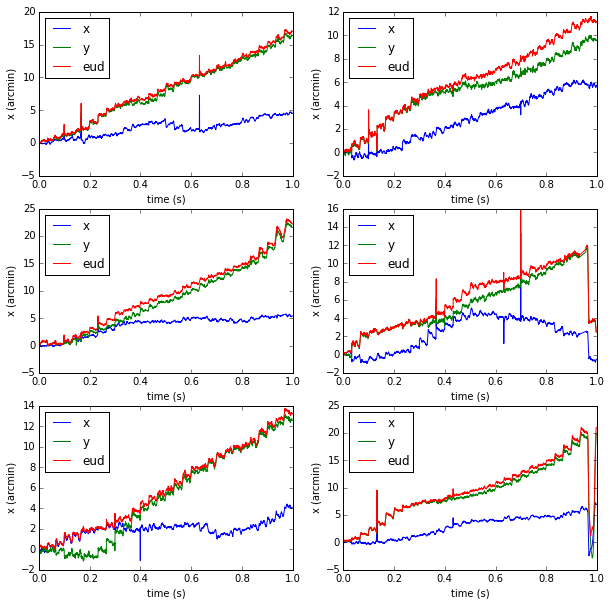

In [20]:
import math

##calc number of rows needed with 2 cols
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

fig, ax = plt.subplots(nrow,ncol, figsize=(10,10))
for i, pl in enumerate(ax.flatten()):
    trial = trials[i]
    pl.plot(trial.time, trial.x, label = 'x')
    pl.plot(trial.time, trial.y, label = 'y')
    pl.plot(trial.time, (trial.x**2 + trial.y**2)**.5, label = 'eud')

    pl.set_xlabel('time (s)')
    pl.set_ylabel('x (arcmin)')
    pl.legend(loc = 0)
plt.show()
   

### Plot Trajectories - x and y together

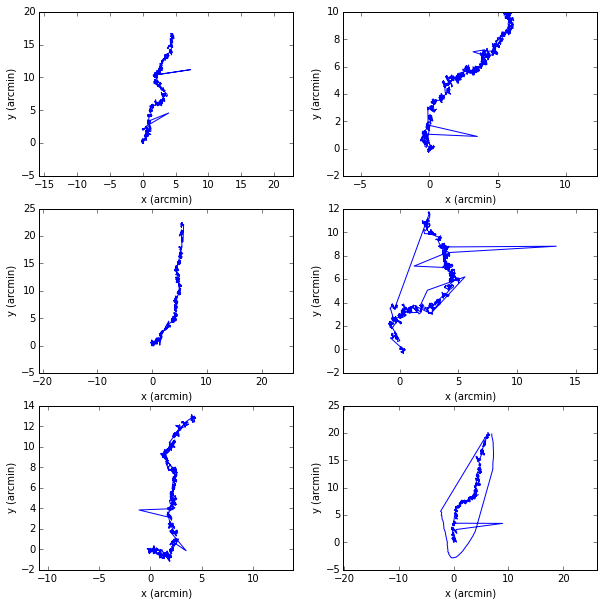

In [21]:
fig, ax = plt.subplots(nrow,ncol, figsize=(10,10))
for i, pl in enumerate(ax.flatten()):
    trial = trials[i]
    pl.plot(trial.x, trial.y)
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.axis('equal')
plt.show()

### Plot Trajectories - x and y togeter with timecourse

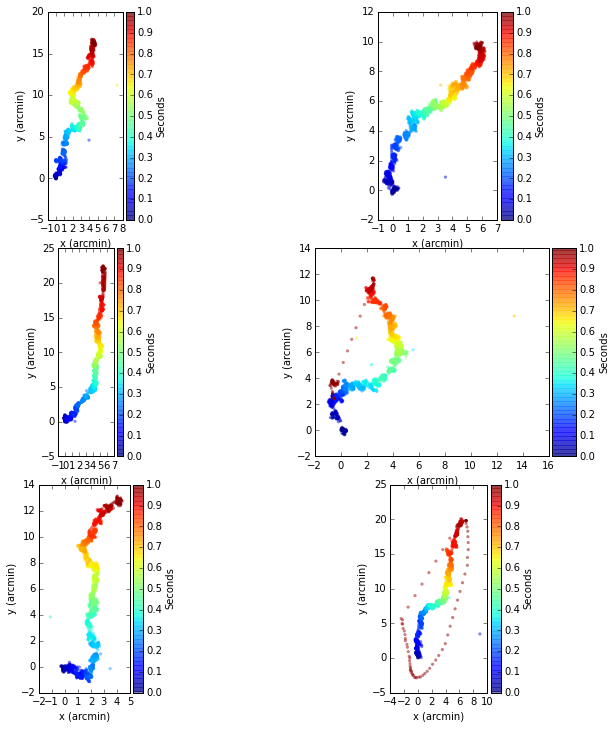

In [22]:
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Show early -> late progression
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

for i, pl in enumerate(ax.flatten()):
    trial = trials[i]
    im = pl.scatter(trial.x, trial.y, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Seconds')

plt.show()

This is interesting. In the x, we are moving a relatively short distance. 0.5 armins corresponds to one foveal cone, so we are really only moving a few arcmins, maybe up to 15 foveal cones horizontally, but vertically, we move a much larger distance, somtimes over 15 arcmins, or 30+ foveal cones!  

Plot velocity also

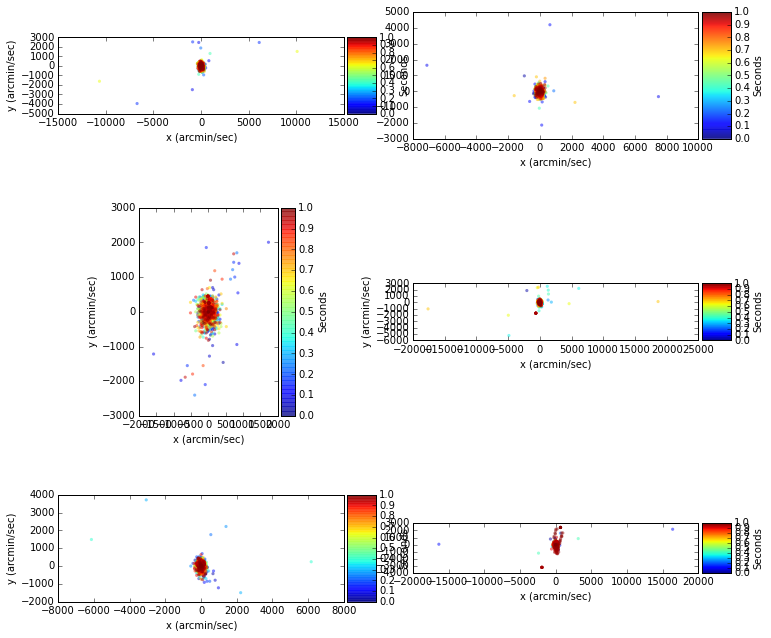

In [23]:
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Show early -> late progression
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

for i, pl in enumerate(ax.flatten()):
    trial = trials[i]
    im = pl.scatter(trial.xv, trial.yv, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin/sec)')
    pl.set_ylabel('y (arcmin/sec)')
    pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Seconds')

plt.show()

In [24]:
##DEBUGGING
print trials[1].yv
print trials[1].y[0]
print trials[1].y[1]
print (trials[1].y[1] - trials[1].y[0])
print (trials[1].y[1] - trials[1].y[0]) * len(trial.time)

[ 212.77044855  212.77044855 -243.16622691 ...,    0.            0.            0.        ]
0.0
0.110817941953
0.110817941953
212.770448549


## Filtering

There are jumps in the data. We should smooth them out/remove them using a filter. 

Main problems with the Data:

1. Outliers due to mirror failure. These are shown as the large jumps out to the side, the most extreme as seen in the 4th sample, at ~075ms. We can remove these relatively easily by looking for large jumps based on a large deviation from 1 or 2 SDs of the local area, then interpolating.

2. General 'messy' data. Examples of these are in the 4th and 6th trials, where the eye trace goes way off the normal trajectory, sometimes circling around ranging from 8arcmins (sample4) to 20arcmins (sample 6). Intersstingly, the two cases both occur at the very end of the trial. These can be removed by cutting off the end of the trial at that point.

3. Smoothing: All significant figures below the actual threshold of detectio of the AOSLO should be smoothed out. Look at implementing specifically the Kalmann smoothing which takes into account t-1 (past) and t+1 (future) events instead of the Kalmann filter that only uses previous timepoints when estimating position and velocity. Another thing to check: we should know from the specs of the AOSLO what our expected error is. If we take it from the paper (Arathorn, 2007 Retinally stabilized cone-targeted stimulus delivery), it is reported to be average 0.26arcmin, meaning any movement smaller than that should be smoothed out.

### Remove Outliers

#### Make a filtered dataset

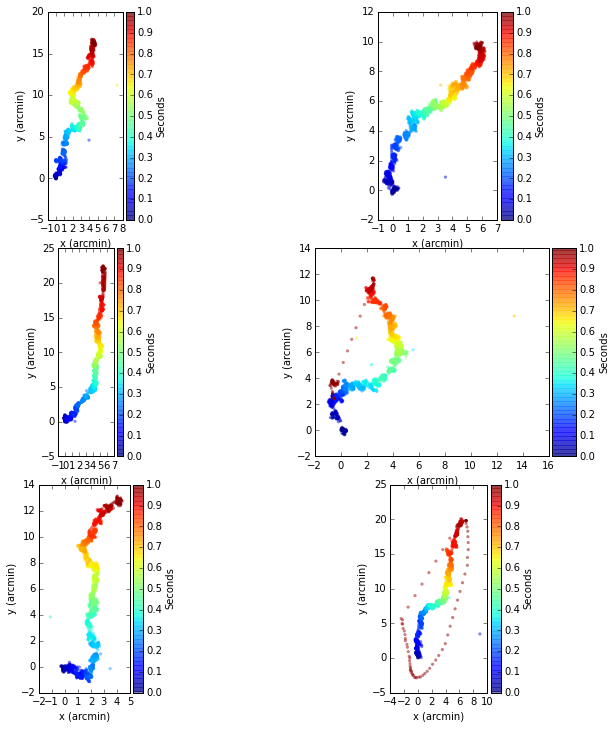

In [25]:
import numpy as np
import matplotlib.cm as cm
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable

def new_dataset(mytrials):
    #new list holding filtered trials.
    mytrialsf = list()
    for trial in mytrials:
        x = trial.x
        y = trial.y
        t = trial.time
        ftrial = EyeTrace(x, y, t, scale)
        mytrialsf.append(ftrial)
    return mytrialsf

#trialsf = new_dataset(trials)

trialsf = copy.deepcopy(trials)

##pretty plotting
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]
    im = pl.scatter(trial.x, trial.y, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Seconds')

plt.show()

Great. these look the same as our original dataset, so we can continue and fitler them.

#### Removal of non-fixational motion

The largest problems with the data, and what we need to deal with first (i know having gone down the rabbit hole in the other order) is in trials 4 and 6, where we see a small microsaccade (trial 4), and something lik non-fixational eye movement (trial 6). These problems with the data are NOT completally removed by our mirror failure scripts.  

There are a couple ways we could deal with them:  

1. Cutting off the end of the trial (such as trial 6)  - This would leave us with uneven timelengths.

2. in the samples where possible (trial 4), remove the microsaccade and sew together the second fixactional eye movement piece to the last good point before the microsaccade.  - This would also leave us with uneven timelenghs (though not so severe), but also is somewhat fabricated as the eye drift may have different parameters given it was just after a microsaccade.  

3. Remove these trials altogether.  

Given that we have PLENTY of trials to work with, we will remove these samples manually for now, and proceeed with the cleanest of data. In the future when we want to read in ALL the trials Kavitha has given us, we may think about writing a script to detect clean and unclean trials, to make this automated, and less prone to human judgement of what is a 'good' trial.

In [26]:
del trialsf[5]
del trialsf[3]
for trial in trialsf:
    trial.filterinfo = "1) trials with microsaccade-like data discarded.\n"

#### Outlier Detection by FFT
This is based on a tutorial by 'Burga' here: http://bugra.github.io/work/notes/2014-03-31/outlier-detection-in-time-series-signals-fft-median-filtering/

/Users/vgd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


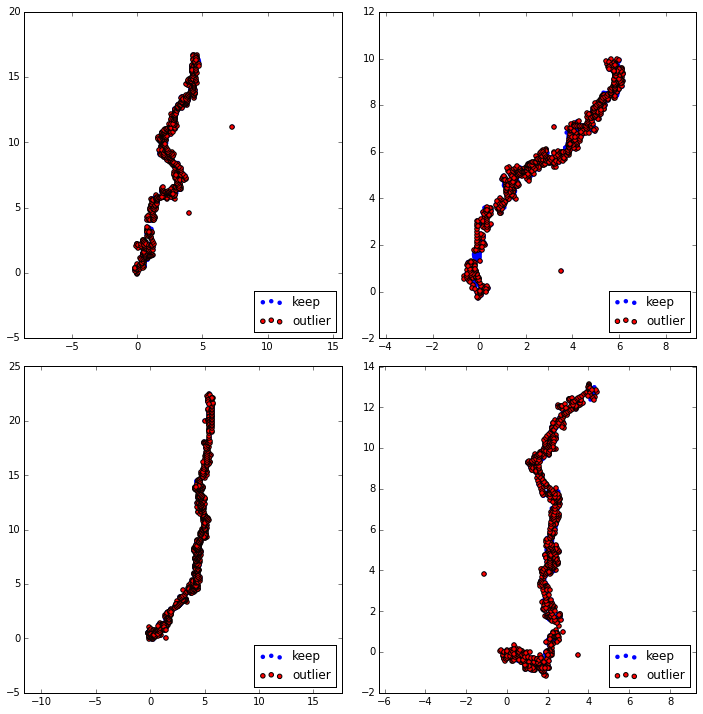

In [27]:
def detect_outliers_fft(signal, threshfq, fqamp):
    signal = signal - np.mean(signal) #normalize to zero
    fft = np.fft.fft(signal)
    if abs(np.max(signal)) > abs(np.min(signal)):
        outlier = np.max(signal)
    else:
        outlier = np.min(signal)
    if np.any(np.abs(fft[threshfq:]) > fqamp ):
        outlieri = np.where(signal == outlier)
        return outlieri[0]
    else:
        return None 
    
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

##pretty plotting
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

##set window size
winsize = 10

for i, pl in enumerate(ax.flatten()):
    ftrial = trialsf[i]
    outliers = []
    
    for i in range(winsize, len(ftrial.x)):
        outlierx = detect_outliers_fft(ftrial.x[i-winsize:i+winsize], threshfq=19.9, fqamp=.65)
        outliery = detect_outliers_fft(ftrial.y[i-winsize:i+winsize], threshfq=19.9, fqamp=.65)
                                      
        if outlierx is not None:
            outliers.append(i + outlierx[0] - winsize)
        if outliery is not None:
            outliers.append(i + outliery[0] - winsize)
    outliers = list(set(outliers))

    
    #pl.figure(figsize=(12, 6))
    pl.scatter(ftrial.x, ftrial.y, c='blue', label='keep', edgecolors='none')
    if(len(outliers) > 0):
        pl.scatter(ftrial.x[np.asanyarray(outliers)], ftrial.y[np.asanyarray(outliers)], c='red', label= 'outlier')
    pl.axis('equal') 
    pl.legend(loc=4)

I can't get this to work well. Small tunings of parameters lead to widely different results. It seems impossible to tune with these two parameterd down to just the real obvious mirror failure outliers, and not the ones well within the main trajectory. Perhaps our data has too many frequencies to easily do this. Indeed the example dataset was a simple sinusoidal with gaussian nosie added. Let's try a different method.

#### Outlier Detection by Mean Absolute Deviation (MAD)

The mean average deviation is a good metric for window sizes that might not be consistent. We keep the same window size throughout, however, calculating how much a given point differs in the x and y from those near it.

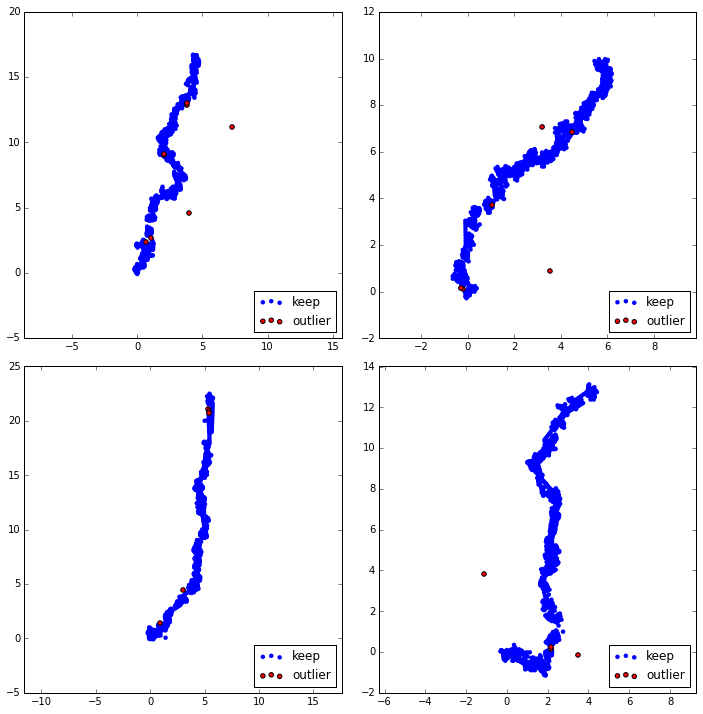

In [28]:
import numpy as np
import matplotlib.cm as cm

##define outlier detection function based on mean absolute deviation
##adapted from http://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def find_outliers_mad(signal, thresh):
    if len(signal.shape) == 1:
        signal = signal[:,None]
    median = np.median(signal, axis=0)
    diff = np.sum((signal - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / ( med_abs_deviation + 1e-10)
    return np.where(modified_z_score > thresh)


def find_outliers_sd(signal, thresh):
    diff = (100 - thresh) / 2.0
    minval, maxval = np.percentile(signal, [diff, 100 - diff])
    return np.where((signal < minval) | (signal > maxval))[0]


##set window size: Note 40 is the time of 
halfwinsize = 45
madthresh = 8
sdthresh = 99.999

##ones I've tried that are decent for mad: 
##50,8 (too many false positives)
##50,10 (too many false negatives)
##40,10 (really damn close but a couple false positives)
##45,10 (also really damn close but a couple false positives, and a few more false negatives now too)
##40,12 (best so far, but one false negative, 1 false positive)
##40,11 (one false negative)
##41,12 (one false positive)
##41,11 (one false positive)
##45,12 (pretty good)

##pretty plotting
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

##iterate over trials
for i, pl in enumerate(ax.flatten()):
    ftrial = trialsf[i]
    outliers = []
    ##run window
    for i in range(halfwinsize, len(ftrial.x)-halfwinsize):
        ##calc based on MAD
        outliersx = find_outliers_mad(ftrial.x[i-halfwinsize:i+halfwinsize], madthresh)[0]
        outliersy = find_outliers_mad(ftrial.y[i-halfwinsize:i+halfwinsize], madthresh)[0] 
        ##calc based on SD
        #outliersx = find_outliers_sd(ftrial.x[i-halfwinsize:i+halfwinsize], thresh)
        #outliersy = find_outliers_sd(ftrial.y[i-halfwinsize:i+halfwinsize], thresh) 
        if len(outliersx) > 0:
            ##check that t-1 is not also an outlier (aka this is not the case of the first timepoint after return from mirror failure, also a large displacement.)
            for o in outliersx:
                if o-1 in outliersx: outliersx = outliersx[np.where(outliersx == o-1)]
            outliers.append(i + outliersx[0] - halfwinsize)
        if len(outliersy) > 0:
            for o in outliersy:
                if o-1 in outliersy: outliersy = outliersy[np.where(outliersy == o-1)]
            outliers.append(i + outliersy[0] - halfwinsize)
    #print i
    outliers = list(set(outliers))
   
    ##plot
    pl.scatter(ftrial.x, ftrial.y, c='blue', label='keep', edgecolors='none')
    if len(outliers) > 0:
        pl.scatter(ftrial.x[np.asanyarray(outliers)], ftrial.y[np.asanyarray(outliers)], c='red', label= 'outlier')
    pl.axis('equal') 
    pl.legend(loc=4)


After playing with parameters a bit, a half window size of 45, with a limit of z-score 8 seems to be just right. This is interesting because in Alex's sliding window analysis, he mentioned that the Roorda group recommended a window size of 7 for smoothing. However, that was the recommended parameter for smoothing, and this for the outlier detection, could have someething to do with being just above the 40Hz limit, where we see the effect of stitching? Although, relative to our data, the refresh of a given strip is actually every 48 frames.   

This is pretty good. However, I think we can do a little bit better if we calcluate the mad based on the instintaneous displacement, rather than position. Then we don't have to window!  

#### Outler Detection using instintaneous displacement and hard threshold

The characteristic of a mirror failure is a large displacement for one frame, and then a return to normal eye location. So instead of basing our analysis on position, let's use the acutal metric, the displacement between two timepoints, which is crazy large for mirror failures.

According to literature, human drift is 6-24.6deg/s. This would correspond in our data to:  

Min: (6*60)arcmins/1920 frame) = .1875 arcmins/frame.  
Max: (24.6*60)arcmins/1920 frame) = .7687 arcmins/frame.

Anything above that should be a microsaccade. 

Given this as a threshold, we can detect non-drift movement using this criteria.

Now plot in xyspace and interpolate the values for outliers

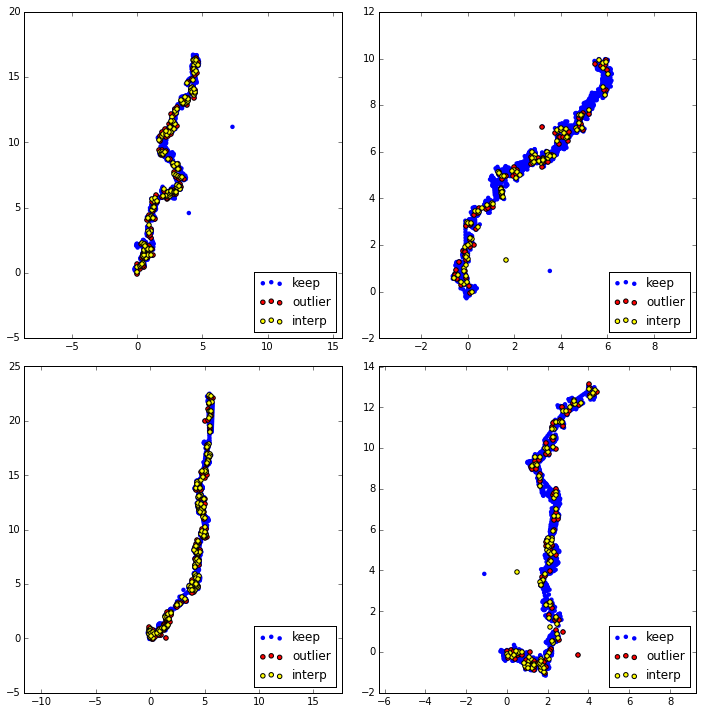

In [29]:
import numpy as np
import matplotlib.cm as cm

##the threshold in arcmins/frame to exceed drift
hardthresh = .1875

##pretty plotting
##calc number of rows needed with 2 cols 
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

##iterate over trials
for i, pl in enumerate(ax.flatten()):

    trial = trialsf[i]
    
    ##the displacement is t+1 - t
    xt1 = trial.x[:-1]
    xt2 = trial.x[1:]
    xd = xt2-xt1 ##THIS IS OK for Numpy Arrays
    yt1 = trial.y[:-1]
    yt2 = trial.y[1:]
    yd = yt2-yt1
    eud = np.append([0],(xd**2 + yd**2)**.5) #add zero so we have zero displacement for t=0
    #eud = (xd**2 + yd**2)**.5 #interstingly, this seems to work too. Probably because after mirror failure there is a large displacement back to normal signal.
    ##get the list of outliers
    outliers = np.where(abs(eud) > hardthresh)[0]
    #outliers = list(set(outliers))
    foutliers= np.array(outliers)
    
    
    ##plot original values
    pl.scatter(trial.x, trial.y, c='blue', label='keep', edgecolors='none') ##note these aren't really only the keepers. Outlier values are hidden under outlier plot
    
    ##check that t-1 is not also an outlier (aka this is not the case of the first timepoint after return from mirror failure, also a large displacement.)
    #print "outliers before filtering:"
    #print outliers
    if(len(outliers)>0):
        for o in outliers:
            if (o+1 in foutliers) & (o-1 in foutliers):
                #print 'found'
                #print o+1
                #print 'found'
                #print o-1
                #print 'removing'
                #print o+1
                #print 'removing'
                #print o-1
                foutliers = foutliers[foutliers != o+1]
                foutliers = foutliers[foutliers != o-1]
            elif (o-1 in foutliers):
                #print 'found'
                #print o-1
                #print 'removing'
                #print o
                foutliers = foutliers[foutliers != o]

#            if o+1 in outliers:
#                np.delete(foutliers, np.where(foutliers == o)[0])
                
        #print"outliers after filtering"
        #print foutliers
        pl.scatter(trial.x[foutliers], trial.y[foutliers], c='red', label= 'outlier')
        ##now interpolate
        interpx = (trial.x[foutliers-1] + trial.x[foutliers+1]) / 2
        interpy = (trial.y[foutliers-1] + trial.y[foutliers+1]) / 2
        pl.scatter(interpx, interpy, c='yellow', label= 'interp')

        #now replace outliers with the interpolated values for the trial
        #trial.x[foutliers] = interpx
        #trial.y[foutliers] = interpy
        #trial.filterinfo = trial.filterinfo.append("2) %s mirror failures detected and interpolated."%len(foutliers))
   
    pl.axis('equal') 
    pl.legend(loc=4)
    

We see many non-mirror failures being classified as true movement, though given the dissimilarity between the overall variances between the 4 samples, this might actually make sense. Changing this value arbitrarilty though, seems... arbitrary. And it seems more likely that non-drift values would vary from person to person.

#### Outler Detection using instintaneous displacement and relative threshold
Let's use a metric relative to each individual, the mean average for the whole trial.

First Let's plot linear displacement to see where along the timecourse we should expect to see outliers.

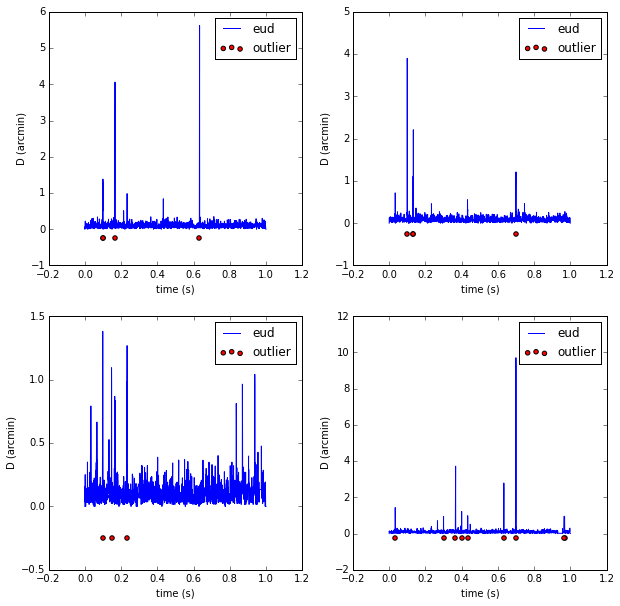

In [30]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) #, sharex = True )

##calc number of rows needed with 2 cols (one for each of re/im/mag part of FFT)
ncol = 2
nrow = int(math.ceil(len(trials) / ncol))

madthresh=16

for i, pl in enumerate(ax.flatten()):

    trial = trials[i]

    ##the displacement is t+1 - t
    xt1 = trial.x[:-1]
    xt2 = trial.x[1:]
    xd = xt2-xt1 ##THIS IS OK for Numpy Arrays
    yt1 = trial.y[:-1]
    yt2 = trial.y[1:]
    yd = yt2-yt1
    eud = np.append(np.array([0]),(xd**2 + yd**2)**.5)
    
    ##find outliers
    outliers = find_outliers_mad(eud, madthresh)[0]
    outliers = list(set(outliers))
    foutliers = np.array(outliers)
    if(len(outliers)>0):
        for o in outliers:
            if (o+1 in foutliers) & (o-1 in foutliers):
                #print 'found'
                #print o+1
                #print 'found'
                #print o-1
                #print 'removing'
                #print o+1
                #print 'removing'
                #print o-1
                foutliers = foutliers[foutliers != o+1]
                foutliers = foutliers[foutliers != o-1]
            elif (o-1 in foutliers):
                #print 'found'
                #print o-1
                #print 'removing'
                #print o
                foutliers = foutliers[foutliers != o]
    
    pl.plot(trial.time, eud, label = 'eud')
    pl.scatter(ftrial.time[np.asanyarray(foutliers)], np.zeros(len(foutliers))-.25, c='red',label = 'outlier')
    
    #pl.set_xscale('log')
    #pl.set_yscale('log')
    
    pl.set_xlabel('time (s)')
    pl.set_ylabel('D (arcmin)')


    pl.legend(loc = 0)    

We notice here that the relatively clean trial (lower left) gets mirror failures marked that would not be marked in other trials, simply because the trial has a lower average deviation. Let's see how the x-y traces look though.

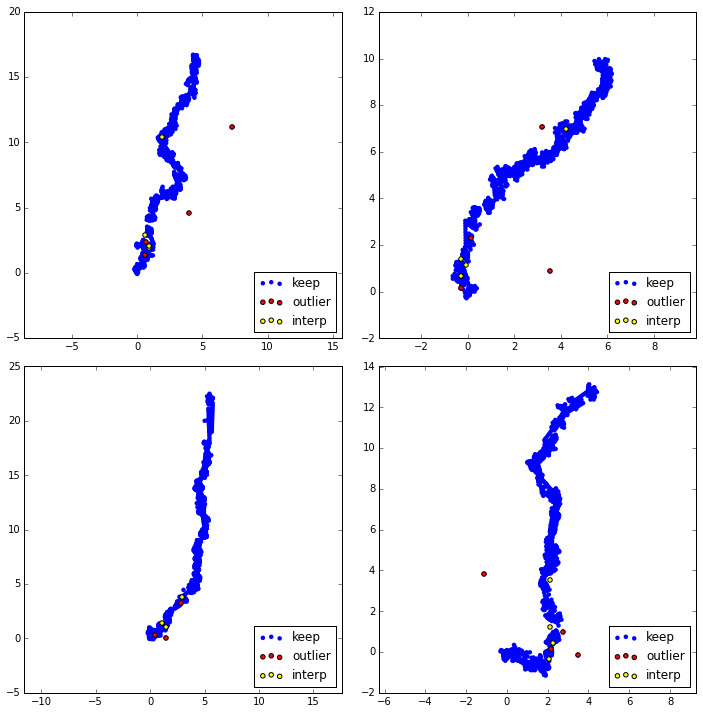

In [31]:
import numpy as np
import matplotlib.cm as cm

##pretty plotting
##calc number of rows needed with 2 cols 
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

##iterate over trials
for i, pl in enumerate(ax.flatten()):

    trial = trialsf[i]

    ##the displacement is t+1 - t
    xt1 = trial.x[:-1]
    xt2 = trial.x[1:]
    xd = xt2-xt1 ##THIS IS OK for Numpy Arrays
    yt1 = trial.y[:-1]
    yt2 = trial.y[1:]
    yd = yt2-yt1
    eud = np.append([0],(xd**2 + yd**2)**.5) #add zero so we have zero displacement for t=0
    #eud = (xd**2 + yd**2)**.5 #interstingly, this seems to work too. Probably because after mirror failure there is a large displacement back to normal signal.
    ##get the list of outliers
    outliers = find_outliers_mad(eud, madthresh)[0]
    #outliers = list(set(outliers))
    outliers= np.array(outliers)
    
    ##check that t-1 is not also an outlier (aka this is not the case of the first timepoint after return from mirror failure, also a large displacement.)
    foutliers = np.array(outliers)
    #print "outliers before filtering:"
    #print outliers
    if(len(outliers)>0):
        for o in outliers:
            if (o+1 in foutliers) & (o-1 in foutliers):
                #print 'found'
                #print o+1
                #print 'found'
                #print o-1
                #print 'removing'
                #print o+1
                #print 'removing'
                #print o-1
                foutliers = foutliers[foutliers != o+1]
                foutliers = foutliers[foutliers != o-1]
            elif (o-1 in foutliers):
                #print 'found'
                #print o-1
                #print 'removing'
                #print o
                foutliers = foutliers[foutliers != o]

#            if o+1 in outliers:
#                np.delete(foutliers, np.where(foutliers == o)[0])
                
        #print"outliers after filtering"
        ##plot original values
        pl.scatter(trial.x, trial.y, c='blue', label='keep', edgecolors='none') ##note these aren't really only the keepers. Outlier values are hidden under outlier plot
        #print foutliers
        pl.scatter(trial.x[foutliers], trial.y[foutliers], c='red', label= 'outlier')
        ##now interpolate
        interpx = (trial.x[foutliers-1] + trial.x[foutliers+1]) / 2
        interpy = (trial.y[foutliers-1] + trial.y[foutliers+1]) / 2
        pl.scatter(interpx, interpy, c='yellow', label= 'interp')

        #now replace outliers with the interpolated values for the trial
        trial.x[foutliers] = interpx
        trial.y[foutliers] = interpy
        trial.filterinfo = trial.filterinfo +'2) %s mirror failures detected and interpolated.\n'%len(foutliers)
   
    pl.axis('equal') 
    pl.legend(loc=4)
    

In [32]:
for trial in trialsf:
    print trial.filterinfo

1) trials with microsaccade-like data discarded.
2) 4 mirror failures detected and interpolated.

1) trials with microsaccade-like data discarded.
2) 4 mirror failures detected and interpolated.

1) trials with microsaccade-like data discarded.
2) 3 mirror failures detected and interpolated.

1) trials with microsaccade-like data discarded.
2) 4 mirror failures detected and interpolated.



Looks pretty good, though it's worth noting that no matter what we are over-classifying mirror failures. Worst case scenereo we smoothed our data a little bit more than needed. Interpolating on fewer than 5 points in all cases is not bad.

##  Plot FFT & Power Spectrum 

Let's see what the power spectrum looks like for this data. Then try to combine samples and calculate.

### Alex's Method - Power Spectrum

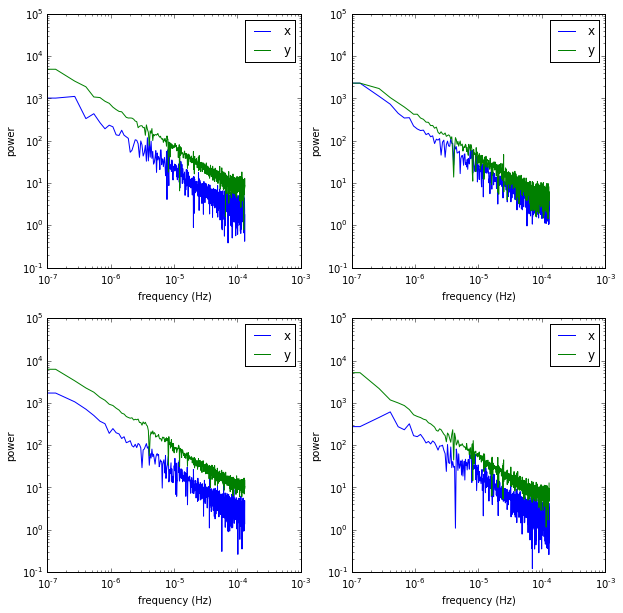

In [33]:
import numpy as np
from scipy.fftpack import fft

fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
tstep = float(2*len(trialsf[0].x)) #this is the Nyquist frequency (2x sampling rate)

for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]
    
    #X direction
    xfq = np.fft.fftshift(np.fft.fftfreq(len(trial.x), tstep))
    xps = np.fft.fftshift(np.abs(np.fft.fft(trial.x)))
    #Y direction
    yfq = np.fft.fftshift(np.fft.fftfreq(len(trial.y), tstep))
    yps = np.fft.fftshift(np.abs(np.fft.fft(trial.y)))
    ##plot it
    pl.plot(xfq, xps, label = 'x')
    pl.plot(yfq, yps, label = 'y')
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('frequency (Hz)')
    pl.set_ylabel('power')
    ##legend
    pl.legend(loc = 0)
plt.show()


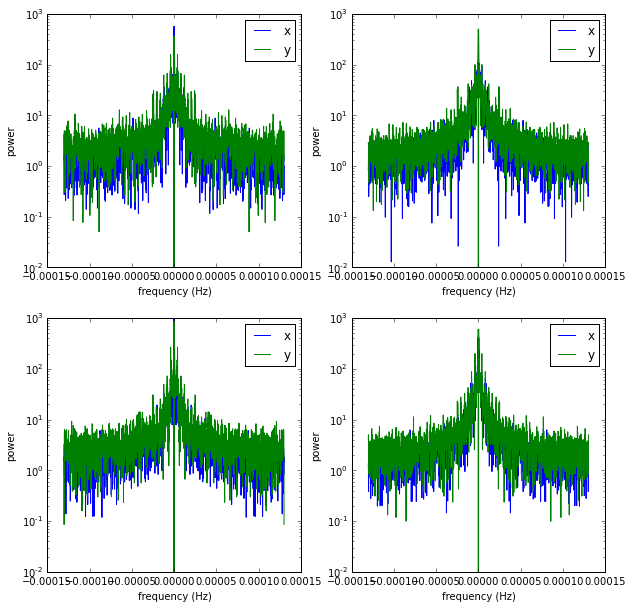

In [34]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal

fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
tstep = float(2*len(trialsf[0].x)) #this is the Nyquist frequency (sampling rate 2x signal)
#tstep = 10000

for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]
    
    ##normalize data
    x = trial.x - np.mean(trial.x)
    y = trial.y - np.mean(trial.y)
    ##detrend
    x = signal.detrend(x)
    y = signal.detrend(y)

    #X direction
    xfq = np.fft.fftshift(np.fft.fftfreq(len(x), tstep))
    xps = np.fft.fftshift(np.abs(np.fft.fft(x)))
    #Y direction
    yfq = np.fft.fftshift(np.fft.fftfreq(len(y), tstep))
    yps = np.fft.fftshift(np.abs(np.fft.fft(y)))
    ##remove zero
    xps[xfq==0] = 0
    yps[yfq==0] = 0
    ##plot it
    pl.plot(xfq, xps, label = 'x')
    pl.plot(yfq, yps, label = 'y')
    ##log scale
    #pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('frequency (Hz)')
    pl.set_ylabel('power')
    ##legend
    pl.legend(loc = 0)
plt.show()


### My own implementation

adapted from: http://snowball.millersville.edu/~adecaria/ESCI386P/esci386-lesson17-Fourier-Transforms.pdf

#### Power Spectrum Only

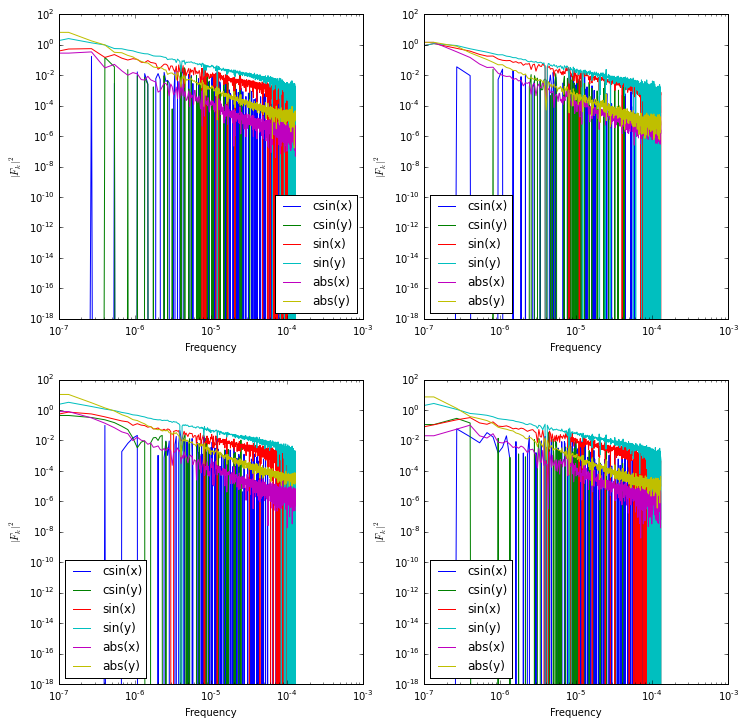

In [35]:
import numpy as np
from scipy.fftpack import fft

fig, ax = plt.subplots(nrow, ncol, figsize=(12,12)) #, sharex = True )
tstep = float(2*len(trialsf[0].x)) #this is the Nyquist frequency (2x sampling rate)

##calc number of rows needed with 2 cols (one for each of re/im/mag part of FFT)
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]
    #X direction
    xnu = np.fft.fftshift(np.fft.fftfreq(len(trial.x),tstep))
    xfq = np.fft.fftshift(np.fft.fft(trial.x)/len(trial.x))
    xfqre = np.real(xfq) #real terms (cosine)
    xfqim = np.imag(xfq) #imaginary terms (sine)
    xfqabs = np.absolute(xfq**2) #spectral power
    #Y direction
    ynu = np.fft.fftshift(np.fft.fftfreq(len(trial.y),tstep))
    yfq = np.fft.fftshift(np.fft.fft(trial.y)/len(trial.y))
    yfqre = np.real(yfq) #real terms (cosine)
    yfqim = np.imag(yfq) #imaginary terms (sine)
    yfqabs = np.absolute(yfq**2) #spectral power

    ##plot real (cosine)
    pl.plot(xnu, xfqre, label = 'csin(x)')
    pl.plot(ynu, yfqre, label = 'csin(y)')
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('Frequency')
    pl.set_ylabel(r'$Re[F_k]$')

    ##legend
    #pl.legend(loc = 0)    
    
    ##plot imaginary (sine)
    pl.plot(xnu, xfqim, label = 'sin(x)')
    pl.plot(ynu, yfqim, label = 'sin(y)')
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('Frequency')
    pl.set_ylabel(r'$Im[F_k]$')
    ##legend
    #pl.legend(loc = 0)   
    
    ##plot spectral power (magnitude)
    pl.plot(xnu, xfqabs, label = 'abs(x)')
    pl.plot(ynu, yfqabs, label = 'abs(y)')
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('Frequency')
    pl.set_ylabel(r'$\vert F_k \vert ^2$')
    ##legend
    pl.legend(loc = 0)   
    
#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-3]], visible=False)    
plt.show()


In [36]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 100;

<IPython.core.display.Javascript object>

#### Separate imaginary, real, and magnitude

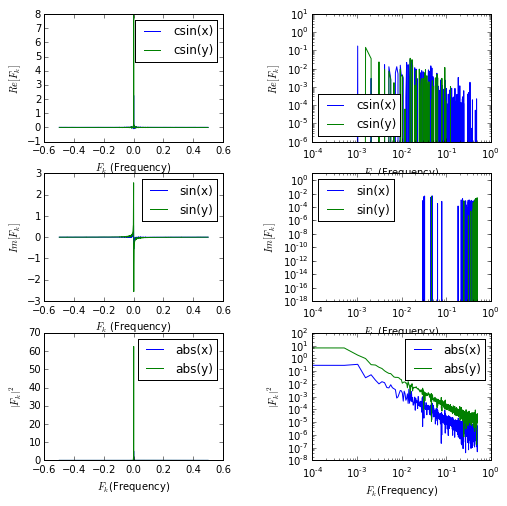

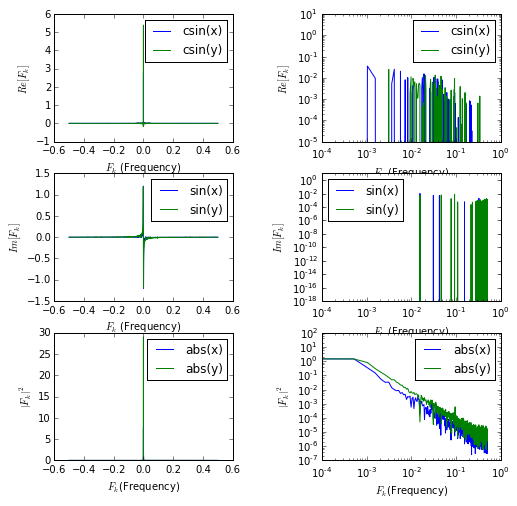

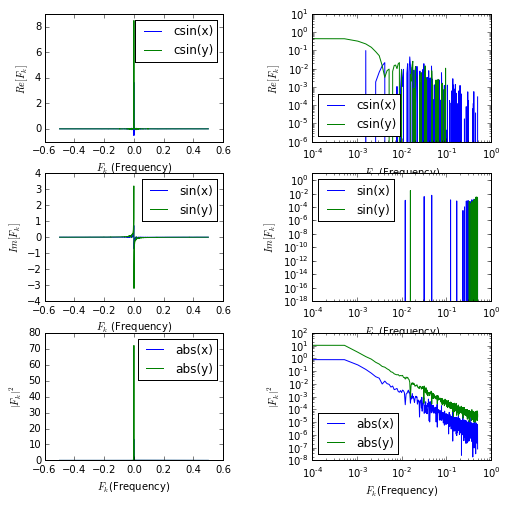

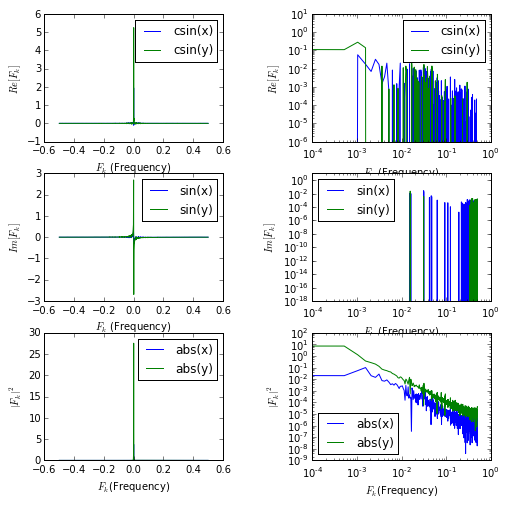

In [37]:
import numpy as np
from scipy.fftpack import fft

tstep = 1/float(2*len(trialsf[0].x))-1 #this is the Nyquist frequency (2x sampling rate)
#tstep = 10

##calc number of rows needed with 2 cols (one for each of re/im/mag part of FFT)
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i in range(0,len(trialsf)):
    trial = trialsf[i]
    
    #X direction
    xnu = np.fft.fftshift(np.fft.fftfreq(len(trial.x), tstep))
    xfq = np.fft.fftshift(np.fft.fft(trial.x)/len(trial.x))
    xfqre = np.real(xfq) #real terms (cosine)
    xfqim = np.imag(xfq) #imaginary terms (sine)
    xfqabs = np.absolute(xfq**2) #spectral power
    #Y direction
    ynu = np.fft.fftshift(np.fft.fftfreq(len(trial.y), tstep))
    yfq = np.fft.fftshift(np.fft.fft(trial.y)/len(trial.y))
    yfqre = np.real(yfq) #real terms (cosine)
    yfqim = np.imag(yfq) #imaginary terms (sine)
    yfqabs = np.absolute(yfq**2) #spectral power

    fig, ax = plt.subplots(3,2, figsize=(8,8), sharex = False )
    
    ##non-logged
    ##plot real (cosine)
    ax[0,0].plot(xnu, xfqre, label = 'csin(x)')
    ax[0,0].plot(ynu, yfqre, label = 'csin(y)')
    ##labels
    ax[0,0].set_xlabel('$F_k$ (Frequency)')
    ax[0,0].set_ylabel(r'$Re[F_k]$')
    ##legend
    ax[0,0].legend(loc = 0)    
    
    ##plot imaginary (sine)
    ax[1,0].plot(xnu, xfqim, label = 'sin(x)')
    ax[1,0].plot(ynu, yfqim, label = 'sin(y)')
    ##labels
    ax[1,0].set_xlabel('$F_k$ (Frequency)')
    ax[1,0].set_ylabel(r'$Im[F_k]$')
    ##legend
    ax[1,0].legend(loc = 0)   
    
    ##plot spectral power (magnitude)
    ax[2,0].plot(xnu, xfqabs, label = 'abs(x)')
    ax[2,0].plot(ynu, yfqabs, label = 'abs(y)')
    ##labels
    ax[2,0].set_xlabel('$F_k$(Frequency)')
    ax[2,0].set_ylabel(r'$\vert F_k \vert ^2$')
    ##legend
    ax[2,0].legend(loc = 0)   
    
    
    ##log scale
    
    ##plot real (cosine)
    ax[0,1].plot(xnu, xfqre, label = 'csin(x)')
    ax[0,1].plot(ynu, yfqre, label = 'csin(y)')
    ##log scale
    ax[0,1].set_xscale('log')
    ax[0,1].set_yscale('log')
    ##labels
    ax[0,1].set_xlabel('$F_k$ (Frequency)')
    ax[0,1].set_ylabel(r'$Re[F_k]$')
    ##legend
    ax[0,1].legend(loc = 0)    
    
    ##plot imaginary (sine)
    ax[1,1].plot(xnu, xfqim, label = 'sin(x)')
    ax[1,1].plot(ynu, yfqim, label = 'sin(y)')
    ##log scale
    ax[1,1].set_xscale('log')
    ax[1,1].set_yscale('log')
    ##labels
    ax[1,1].set_xlabel('$F_k$ (Frequency)')
    ax[1,1].set_ylabel(r'$Im[F_k]$')
    ##legend
    ax[1,1].legend(loc = 0)   
    
    ##plot spectral power (magnitude)
    ax[2,1].plot(xnu, xfqabs, label = 'abs(x)')
    ax[2,1].plot(ynu, yfqabs, label = 'abs(y)')
    ##log scale
    ax[2,1].set_xscale('log')
    ax[2,1].set_yscale('log')
    ##labels
    ax[2,1].set_xlabel('$F_k$(Frequency)')
    ax[2,1].set_ylabel(r'$\vert F_k \vert ^2$')
    ##legend
    ax[2,1].legend(loc = 0)   
    
    ##tidy up
    fig.subplots_adjust(hspace=.25, wspace=.5)
    #plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    
plt.show()


This didn't really seem to help much. Either way though, the conclusion is the same that there don't appear to be any strong frequencies in the eye-movement data.

## Reproduce Engbert & Kliegl, 2004

A first step is to reproduce what was done by the Engbert & Kliegl, 2004 paper. See notes here in Modeling section of: [Eye Movement Research Notes: Engbert & Kliegl, 2004](Eye Movement Research Notes.ipynb)  

A brief overview:  

*  Measure temporal evolution of mean square displacement $(\Delta x^2)$ from FBM equation for eye movement: $(\Delta x^2) \propto \Delta t^H$. Use experimental data to calculate $H$ as slope of log-log plot of equation for mean square displacement: $D^2 $ over time $t$ for each time step using equation: $$ D^2 (m) = \frac{1}{N-m}\sum_{i=1}^{N-m}\|{\vec{x}_{i+m} - \vec{x}_i}\|^2$$ where $N$ is number of samples in recorded time series, $m$ is time lag measured as number of data samples.  


*  Sew together time courses without microsaccades and test $H$ again. We have already eliminated microsaccades - or so we think. Some samples we have already looked at contain large jumps. May want to reevaluate these jumps in the future, make sure we are still looking at ONLY drift.

### Relative displacement at each timepoint from last timepoint
as an intermediate step, calculate relative displacement over time - that is how much each timepoint deviates from the previous.

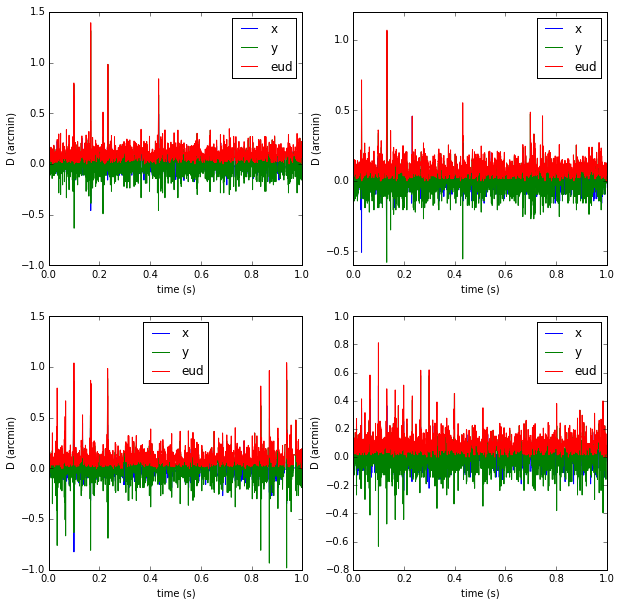

In [38]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) #, sharex = True )

##calc number of rows needed with 2 cols (one for each of re/im/mag part of FFT)
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trialsf[i]

    ##the displacement is t+1 - t
    xt1 = trial.x[:-1]
    xt2 = trial.x[1:]
    xd = xt2-xt1 ##THIS IS OK for Numpy Arrays
    yt1 = trial.y[:-1]
    yt2 = trial.y[1:]
    yd = yt2-yt1
    eud = (xd**2 + yd**2)**.5
    
    pl.plot(trial.time[1:], xd, label = 'x')
    pl.plot(trial.time[1:], yd, label = 'y')
    pl.plot(trial.time[1:], eud, label = 'eud')
    
    #pl.set_xscale('log')
    #pl.set_yscale('log')
    
    pl.set_xlabel('time (s)')
    pl.set_ylabel('D (arcmin)')


    pl.legend(loc = 0)    

Now that we have filtered, this looks good. Now bin the magnitutes at each displacement

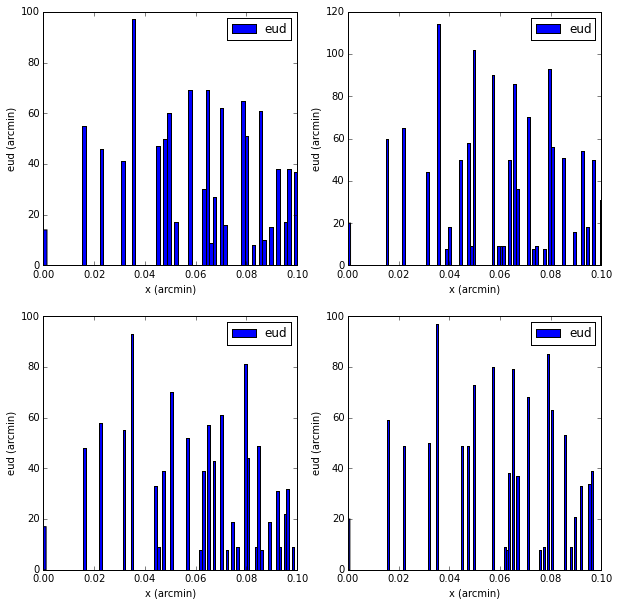

In [39]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) #, sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trialsf[i]

    ##the displacement is t+1 - t
    ##x
    xt1 = trial.x[:-1]
    xt2 = trial.x[1:]
    xd = xt2-xt1
    ##y
    yt1 = trial.y[:-1]
    yt2 = trial.y[1:]
    yd = yt2-yt1
    ##eud
    eud = (xd**2 + yd**2)**.5

    pl.hist(eud, 1000, label = 'eud')
    pl.set_xlim((0,.1))
    
    #pl.set_xscale('log')
    #pl.set_yscale('log')
    
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.set_ylabel('eud (arcmin)')

    pl.legend(loc = 0)    

Interestingly, these distributions look a bit like Poissons. This implies that there is a preference for NOT keeping the same position from timepoint to timepoint. Either that or because the machine goes out to so many decimal points, uncertainty in the machine is much higher than the measurement. That would correspond to a measurement error ~0.01 arcmins. Or something else? We should check with Kavitha on this, because the reported error in the AOSLO is 0.2-0.3 arcmins. This graph implies much lower. 

### Overall Displacement
Now take t=0 as position zero, and calculate the displacement over time, with each timepoint relative to t=0. This is similar to what we did earlier with plotting position, but now we plot the squared values in log space.

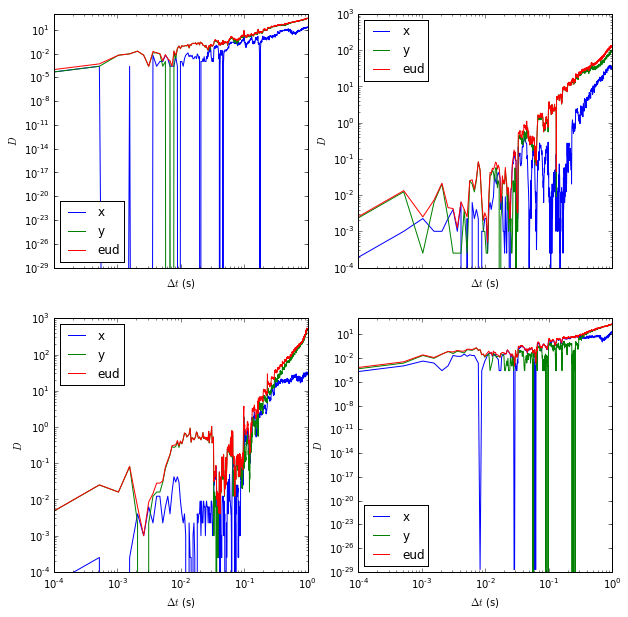

In [40]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trialsf[i]
    
    ##our values for trial.x are already relative to t=0.    
    xd2 = trial.x**2
    yd2 = trial.y**2
    eud = (xd2 + yd2)**.5
    eud2 = eud**2
    
    pl.plot(trial.time, xd2, label= 'x')
    pl.plot(trial.time, yd2, label= 'y')
    pl.plot(trial.time, eud2, label= 'eud')
    
    pl.set_xscale('log')
    pl.set_yscale('log')

    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D$')
    
    pl.legend(loc = 0)

#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

### Normalized Total Cumulative Displacement
Now take t=0 as position zero, and calculate the total displacement over time, by summing up the displacement over all, then dividing by the time.

Perform this calculation of summation of displacement *after* the calculation of euclidian distance.

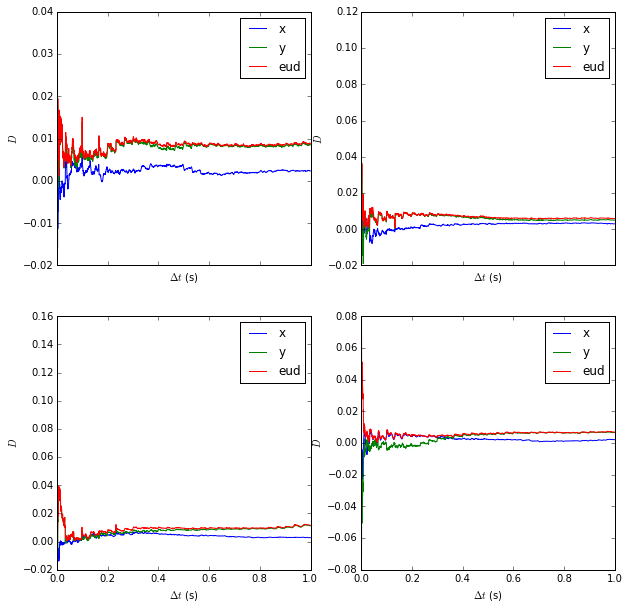

In [41]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trialsf[i]
   
    ##our values for trial.x are already relative to t=0.    
    ranger = np.array([1]+range(1,len(trial.time))) ##make first 2 values 1 so we don't divide by zero
    xdn = trial.x/ranger
    ydn = trial.y/ranger
    eudn = ((trial.x**2 + trial.y**2)**.5)/ranger
    
    pl.plot(trial.time, xdn, label= 'x')
    pl.plot(trial.time, ydn, label= 'y')
    pl.plot(trial.time, eudn, label= 'eud')
    
    #pl.set_xscale('log')
    #pl.set_yscale('log')

    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D$')
    
    pl.legend(loc = 0)

#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

This is intersting. It seems dividing by the raw time value dampens out our displacement. This makes sense as Brownian Motion estimates $$x \propto \sqrt(t)$$ Therefore, we should take the sqrt of our time before dividing if we want to get a straight line.  

Lets try it!

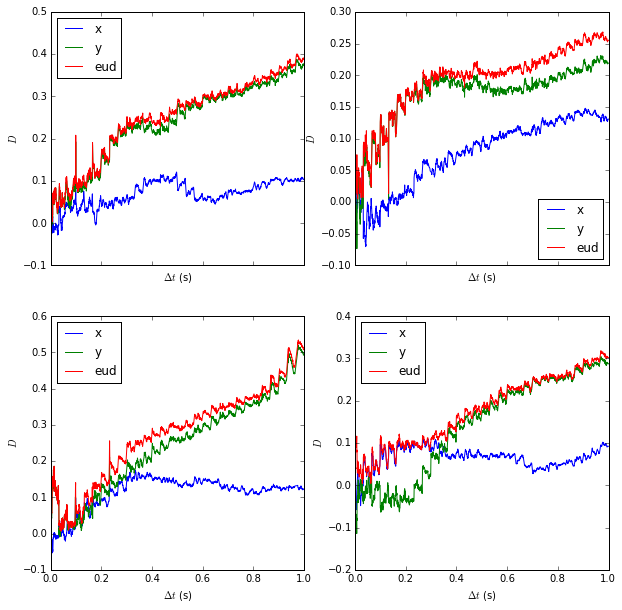

In [42]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trialsf[i]
   
    ##our values for trial.x are already relative to t=0.    
    ##make first 2 values 1 so we don't divide by zero
    ranger = np.sqrt(np.array([1]+range(1,len(trial.time))))
    xdn = trial.x/ranger
    ydn = trial.y/ranger
    eudn = ((trial.x**2 + trial.y**2)**.5)/ranger
    
    pl.plot(trial.time, xdn, label= 'x')
    pl.plot(trial.time, ydn, label= 'y')
    pl.plot(trial.time, eudn, label= 'eud')
    
    #pl.set_xscale('log')
    #pl.set_yscale('log')

    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D$')
    
    pl.legend(loc = 0)

#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

Well, it's not a perfectly straight line, but it's a hell of a lot more interesting, and we can see some serious noise in it now. I wonder what the FFT of this looks like....

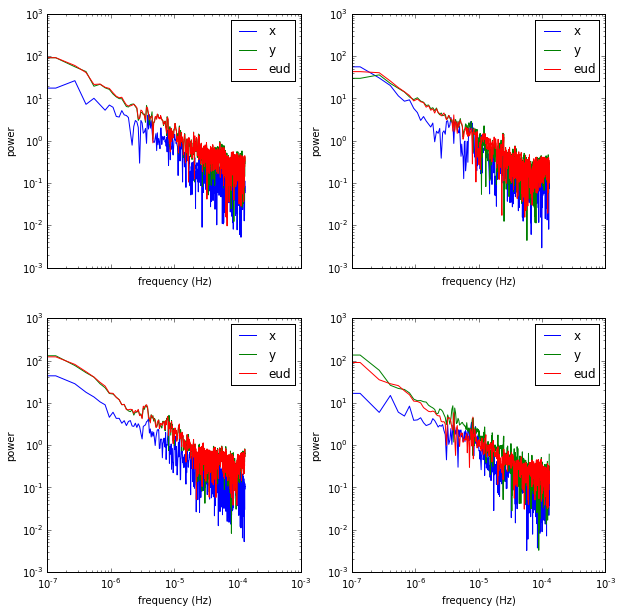

In [43]:
from scipy.fftpack import fft

tstep = float(2*len(trialsf[0].x)) #this is the Nyquist frequency (2x sampling rate)

fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trialsf[i]
   
    ##our values for trial.x are already relative to t=0.    
    ##make first 2 values 1 so we don't divide by zero
    ranger = np.sqrt(np.array([1]+range(1,len(trial.time))))
    xdn = trial.x/ranger
    ydn = trial.y/ranger
    eudn = ((trial.x**2 + trial.y**2)**.5)/ranger

    #X direction
    xfq = np.fft.fftshift(np.fft.fftfreq(len(xdn), tstep))
    xps = np.fft.fftshift(np.abs(np.fft.fft(xdn)))
    #Y direction
    yfq = np.fft.fftshift(np.fft.fftfreq(len(ydn), tstep))
    yps = np.fft.fftshift(np.abs(np.fft.fft(ydn)))
    #Euclidian
    eufq = np.fft.fftshift(np.fft.fftfreq(len(eudn), tstep))
    eups = np.fft.fftshift(np.abs(np.fft.fft(eudn)))
    
    ##plot it
    pl.plot(xfq, xps, label = 'x')
    pl.plot(yfq, yps, label = 'y')
    pl.plot(eufq, eups, label = 'eud')
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('frequency (Hz)')
    pl.set_ylabel('power')
    ##legend
    pl.legend(loc = 0)

plt.show()
#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

Same results as the original signal - no big spikes in power for any frequencies. Oh well, it was worth a shot!

### E&K Equation

#### Implemented using lists
I think the following is garbage, implementing this the long way, and in lists with list comprehension instead of properly with numpy arrays. But leave it just in case it's not.

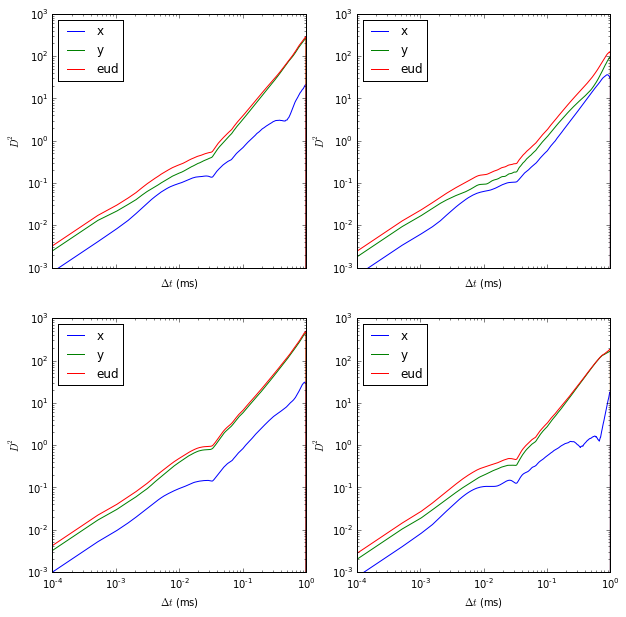

In [44]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]

    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    for m in range(0,len(trial.x)-1):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        xd = [(ximi - xii)**2 for ximi, xii in zip(xim, xi)]
        xdist[m] = sum(xd)/(len(trial.x)-m)
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        yd = [(yimi - yii)**2 for yimi, yii in zip(yim, yi)]
        ydist[m] = sum(yd)/(len(trial.y)-m)
    
        ##euclidian
        #xd2 = [i**2 for i in xd]
        #yd2 = [i**2 for i in yd]
        eud = [np.sqrt(xd2i + yd2i)**2 for xd2i, yd2i in zip(xd, yd)]
        eudist[m] = sum(eud)/(len(trial.x)-m)
    
    pl.plot(trial.time, xdist, label= 'x')
    pl.plot(trial.time, ydist, label= 'y')
    pl.plot(trial.time, eudist, label= 'eud')
    
    pl.set_xscale('log')
    pl.set_yscale('log')

    pl.set_xlabel('$\Delta t$ (ms)')
    pl.set_ylabel('$D^2$')
    
    pl.legend(loc = 0)

#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

#### Using numpy arrays

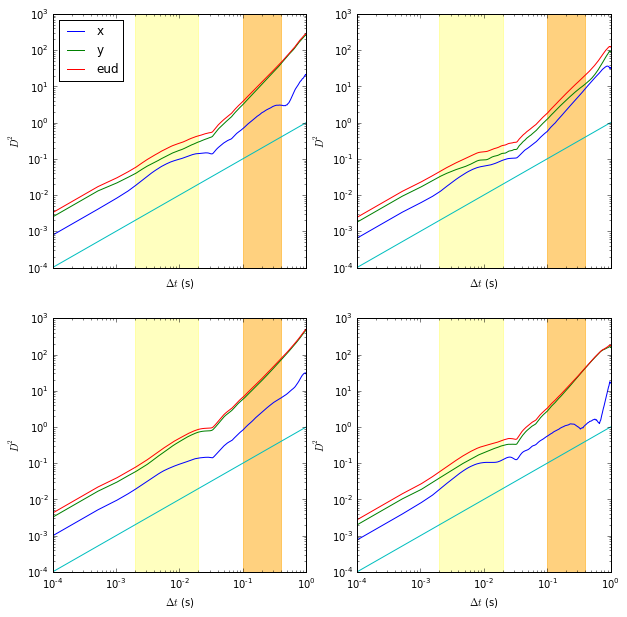

In [45]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time')
    for m in range(1,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##plot x, y, and eud
    pl.plot(trial.time, xdist, label= 'x')
    pl.plot(trial.time, ydist, label= 'y')
    pl.plot(trial.time, eudist, label= 'eud')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    pl.axvspan(.002, .02, alpha=0.25, color='yellow')
    #pl.axvline(.002, color = 'orange')
    #pl.axvline(.02, color = 'orange')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(.1, .4, alpha=0.5, color='orange')
    ##old method
    #pl.axvline(.1, color = 'purple')
    #pl.axvline(.4, color = 'purple')
    
    
    ##also plot line for scaling exponent H = 1
    pl.plot(trial.time, trial.time)
    
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$')
    
    ##legend on first graph only
    if(i==0):
        pl.legend(loc = 0)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

Wow! we get the same result as the other case. We may be doing something correctly here.  

Interstingly, in our data we actually see an INCREASE in rate of displacement increase (scaling factor H) for larger lag times, specifically between 10 and 100 seconds, and more specifically ~20-30 secs. There is a clear knee in the curve at one of these times, and the displacement increases.  

Compare this with the graph from the Engbert & Kliegl paper, where we see a decrease in displacement increase (value of H) at around 30ms.  

![eandkpaper](img/ekgraph.png)

Before we get too excited though, a couple points to consider:  

* The E&K experiment is different than ours, in a lot of ways.  
    * Their data is taken from an EyeLinkII system, ours from an AOSLO.  
    * Sampling frequency for E&K is 100Hz, ours at 1920Hz. At 1920Hz, the Hs measured from 2-20ms, consists of 18ms, or 32 frames (=1920 x 0.018) in our experiment. Wheras in the E&K experiment, the 18ms window is measured  9 frames (=500 x 0.015). The situation is even more drastic in the Hl measured from 100-400ms consists of 300ms, or 576 (=1920 x .3) in our experiment, and 150 (=500 x 0.3) in E&K.
    * E&K experiment INCLUDES microsaccades, which we specifically EXCLUDE.  

* We still have not filtered our data. Though it seems unlikely, perhaps these outliers we need to filter out are affecting our results.


Given this fact about our low sampling rate, lets look at this data on the non logged scale.

### Non-logged

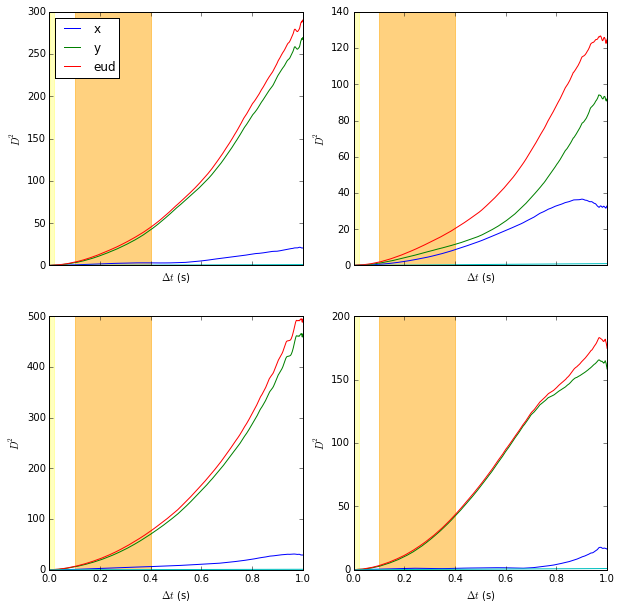

In [46]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time')
    for m in range(1,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##plot x, y, and eud
    pl.plot(trial.time, xdist, label= 'x')
    pl.plot(trial.time, ydist, label= 'y')
    pl.plot(trial.time, eudist, label= 'eud')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    pl.axvspan(.002, .02, alpha=0.25, color='yellow')
    #pl.axvline(.002, color = 'orange')
    #pl.axvline(.02, color = 'orange')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(.1, .4, alpha=0.5, color='orange')
    ##old method
    #pl.axvline(.1, color = 'purple')
    #pl.axvline(.4, color = 'purple')
    
    
    ##also plot line for scaling exponent H = 1
    pl.plot(trial.time, trial.time)
    
    ##log scale
    #pl.set_xscale('log')
    #pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$')
    
    ##legend on first graph only
    if(i==0):
        pl.legend(loc = 0)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)




now we can see what a small portion of our data makes up the Ls window, just how small that window is. Let's go back to log scale, but do a scatterplot to look at how many points actually make up each of these windows.

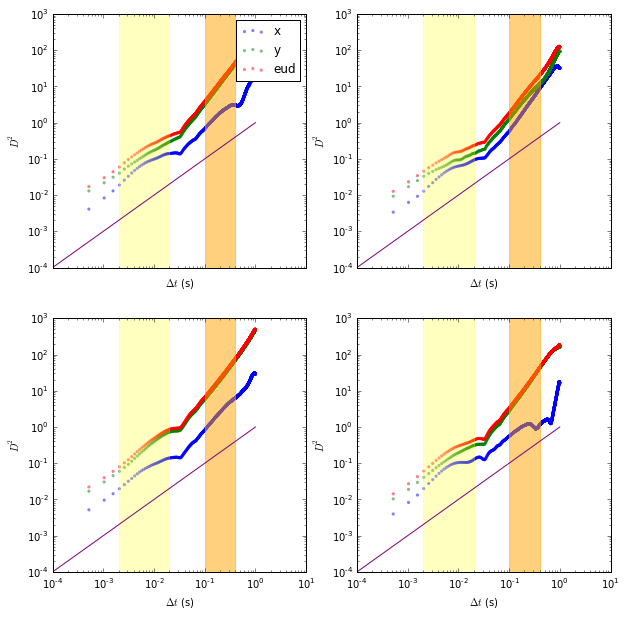

In [47]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time')
    for m in range(1,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##plot x, y, and eud
    pl.scatter(trial.time, xdist, label= 'x', s=10, alpha=0.5, edgecolors='none', color='blue')
    pl.scatter(trial.time, ydist, label= 'y', s=10, alpha=0.5, edgecolors='none', color='green')
    pl.scatter(trial.time, eudist, label= 'eud', s=10, alpha=0.5, edgecolors='none', color='red')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    pl.axvspan(.002, .02, alpha=0.25, color='yellow')
    #pl.axvline(.002, color = 'orange')
    #pl.axvline(.02, color = 'orange')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(.1, .4, alpha=0.5, color='orange')
    ##old method
    #pl.axvline(.1, color = 'purple')
    #pl.axvline(.4, color = 'purple')
    
    ##also plot line for scaling exponent H = 1
    pl.plot(trial.time, trial.time, color='purple')
    
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$')
    
    ##legend on first graph only
    if(i==0):
        pl.legend(loc = 0)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

This confirms our result from calculating the frame rate for the two windows, there is plenty of sampling in our data to get an idea of the slope of the curve for both timepoints. Interestingly though, our slope appears to be constant along a larger time window, particularly for samples 1,2, and 3, Hl could be calculated starting from maybe 50ms. That doesn't seem to hold for trial 6 though.

#### Calculation of H (slope of curve)

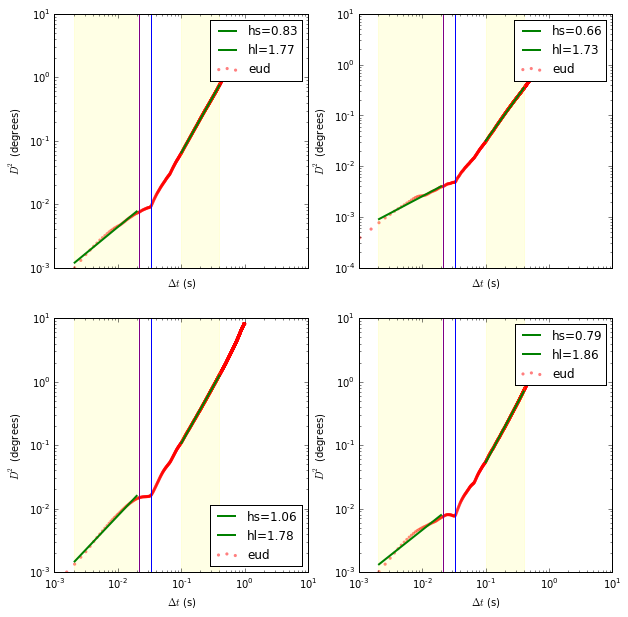

In [48]:
##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

##make figures
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time')
    for m in range(1,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##convert to degrees to compare with paper
    eudist = eudist/60
    
    ##plot x, y, and eud
    #pl.scatter(trial.time, xdist, label= 'x', s=10, alpha=0.5, edgecolors='none', color='blue')
    #pl.scatter(trial.time, ydist, label= 'y', s=10, alpha=0.5, edgecolors='none', color='green')
    pl.scatter(trial.time, eudist, label= 'eud', s=10, alpha=0.5, edgecolors='none', color='red')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    pl.axvspan(0.002, 0.02, alpha=0.1, color='yellow')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(0.1, 0.4, alpha=0.1, color='yellow')

    ##also plot line for scaling exponent H = 1
    #pl.plot(trial.time, trial.time, color='purple')
    
    ##calculate slopes Hs and Hl (at limits from E&K) (Euclidian only)
    ##Hs time 2ms -> 20ms
    hsmask = (trial.time > 0.002) & (trial.time < 0.02)
    hstime = trial.time[hsmask]
    hseudist = eudist[hsmask]
    ##run least square regression of 1st degree on the log-scale values.
    #The equation for a line on a log–log scale would be:
    #log{10}Y = m*log{10}x + b
    #Y = x^m*10^b, 
    #where m is the slope and b is the intercept point on the log plot
    #hslmm, hslmb = np.polyfit(hstime, hseudist, deg=1)
    hslm, hslb = np.polyfit(np.log10(hstime), np.log10(hseudist), deg=1)
    #hsmv = np.add(np.multiply(hslm, hstime), hslb)
    hsmv = hstime**hslm*10**hslb
    #hslmp = np.poly1d(hslm) #convenience class for polynomials
    pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslm,2)))     

    #hsmv = np.add(np.multiply(hslmm, hstime), hslmb)
    #pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslmm,2)))     
    ##Hl time 100ms -> 400ms
    hlmask = (trial.time > 0.1) & (trial.time < 0.4)
    hltime = trial.time[hlmask]
    hleudist = eudist[hlmask]
    ##run least square regression of 1st degree
    hllmm, hllmb = np.polyfit(np.log10(hltime), np.log10(hleudist), deg=1)
    #hlmv = np.add(np.multiply(hllmm, hltime), hllmb)
    hlmv = hltime**hllmm*10**hllmb
    pl.plot(hltime, hlmv, color = 'green', linewidth = 2, label = 'hl=%s'%(round(hllmm,2)))
     
    ##plot knee
    pl.axvline(.033, color = 'blue')
    
    ##plot time to compare one strip to last (41 strips)
    #1/(1920/41) =  0.02135
    pl.axvline(.02135, color = 'purple')
    
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$ (degrees)')
    
    #legend
    pl.legend(loc = 0)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)


#### Removing small displacement
If we believe hs to NOT be true, then remove anything below a displacement of 0.02135 seconds, (41 frames) and plot the line again.

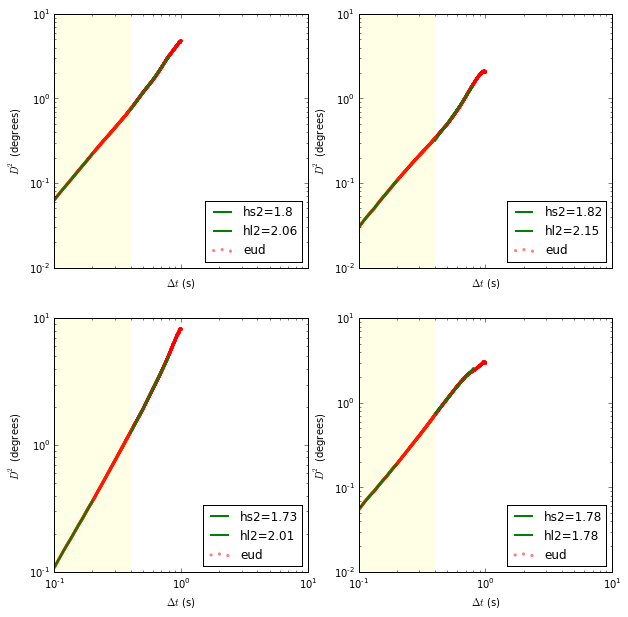

In [49]:
##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

##make figures
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time') ***ABOVE 41***
    for m in range(41,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##convert to degrees to compare with paper
    eudist = eudist/60
    
    ##plot x, y, and eud
    #pl.scatter(trial.time, xdist, label= 'x', s=10, alpha=0.5, edgecolors='none', color='blue')
    #pl.scatter(trial.time, ydist, label= 'y', s=10, alpha=0.5, edgecolors='none', color='green')
    pl.scatter(trial.time, eudist, label= 'eud', s=10, alpha=0.5, edgecolors='none', color='red')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    #pl.axvspan(0.002, 0.02, alpha=0.1, color='yellow')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(0.1, 0.4, alpha=0.1, color='yellow')

    ##also plot line for scaling exponent H = 1
    #pl.plot(trial.time, trial.time, color='purple')
    
    ##calculate slopes Hs and Hl (at limits from E&K) (Euclidian only)
    ##Hs time
    hsmask = (trial.time > 0.1) & (trial.time < 0.2)
    hstime = trial.time[hsmask]
    hseudist = eudist[hsmask]
    ##run least square regression of 1st degree on the log-scale values.
    #The equation for a line on a log–log scale would be:
    #log{10}Y = m*log{10}x + b
    #Y = x^m*10^b, 
    #where m is the slope and b is the intercept point on the log plot
    hslm, hslb = np.polyfit(np.log10(hstime), np.log10(hseudist), deg=1)
    hsmv = hstime**hslm*10**hslb
    pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs2=%s'%(round(hslm,2)))     

    #hsmv = np.add(np.multiply(hslmm, hstime), hslmb)
    #pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslmm,2)))     
    ##Hl time 100ms -> 400ms
    hlmask = (trial.time > 0.4) & (trial.time < 0.8)
    hltime = trial.time[hlmask]
    hleudist = eudist[hlmask]
    ##run least square regression of 1st degree
    hllmm, hllmb = np.polyfit(np.log10(hltime), np.log10(hleudist), deg=1)
    hlmv = hltime**hllmm*10**hllmb
    pl.plot(hltime, hlmv, color = 'green', linewidth = 2, label = 'hl2=%s'%(round(hllmm,2)))
     
    ##plot knee
    #pl.axvline(.033, color = 'blue')
    
    ##plot time to compare one strip to last (41 strips)
    #1/(1920/41) =  0.02135
    #pl.axvline(.02135, color = 'purple')
    
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$ (degrees)')
    
    #legend
    pl.legend(loc = 4)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)


Doesn't seem to be much in the way of a different slope for later timepoints.

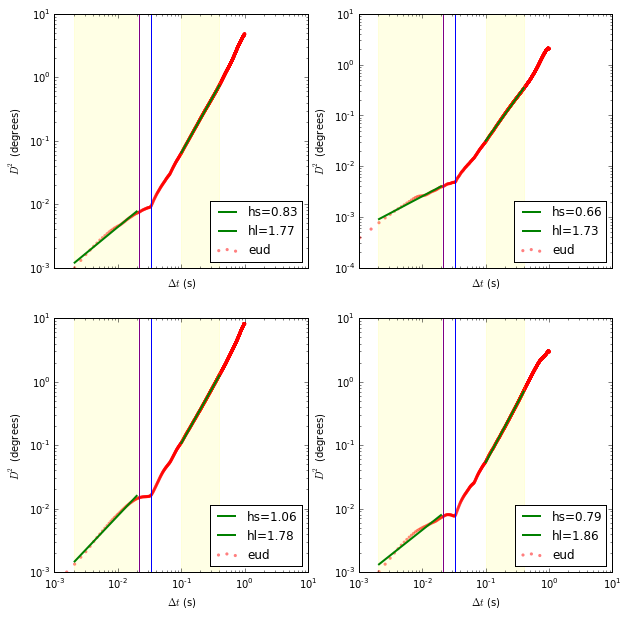

In [50]:
##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

##make figures
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = trialsf[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time')
    for m in range(1,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##convert to degrees to compare with paper
    eudist = eudist/60
    
    ##plot x, y, and eud
    #pl.scatter(trial.time, xdist, label= 'x', s=10, alpha=0.5, edgecolors='none', color='blue')
    #pl.scatter(trial.time, ydist, label= 'y', s=10, alpha=0.5, edgecolors='none', color='green')
    pl.scatter(trial.time, eudist, label= 'eud', s=10, alpha=0.5, edgecolors='none', color='red')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    pl.axvspan(0.002, 0.02, alpha=0.1, color='yellow')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(0.1, 0.4, alpha=0.1, color='yellow')

    ##also plot line for scaling exponent H = 1
    #pl.plot(trial.time, trial.time, color='purple')
    
    ##calculate slopes Hs and Hl (at limits from E&K) (Euclidian only)
    ##Hs time 2ms -> 20ms
    hsmask = (trial.time > 0.002) & (trial.time < 0.02)
    hstime = trial.time[hsmask]
    hseudist = eudist[hsmask]
    ##run least square regression of 1st degree on the log-scale values.
    #The equation for a line on a log–log scale would be:
    #log{10}Y = m*log{10}x + b
    #Y = x^m*10^b, 
    #where m is the slope and b is the intercept point on the log plot
    #hslmm, hslmb = np.polyfit(hstime, hseudist, deg=1)
    hslm, hslb = np.polyfit(np.log10(hstime), np.log10(hseudist), deg=1)
    #hsmv = np.add(np.multiply(hslm, hstime), hslb)
    hsmv = hstime**hslm*10**hslb
    #hslmp = np.poly1d(hslm) #convenience class for polynomials
    pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslm,2)))     

    #hsmv = np.add(np.multiply(hslmm, hstime), hslmb)
    #pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslmm,2)))     
    ##Hl time 100ms -> 400ms
    hlmask = (trial.time > 0.1) & (trial.time < 0.4)
    hltime = trial.time[hlmask]
    hleudist = eudist[hlmask]
    ##run least square regression of 1st degree
    hllmm, hllmb = np.polyfit(np.log10(hltime), np.log10(hleudist), deg=1)
    #hlmv = np.add(np.multiply(hllmm, hltime), hllmb)
    hlmv = hltime**hllmm*10**hllmb
    pl.plot(hltime, hlmv, color = 'green', linewidth = 2, label = 'hl=%s'%(round(hllmm,2)))
     
    ##plot knee
    pl.axvline(.033, color = 'blue')
    
    ##plot time to compare one strip to last (41 strips)
    #1/(1920/41) =  0.02135
    pl.axvline(.02135, color = 'purple')
    
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$ (degrees)')
    
    #legend
    pl.legend(loc = 4)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)


### Discussion
Once figuring out the correct equation for plotting, these slopes hs and hs appear to fit well to the data for euclidian distance.

For our data, hs is distinctly lower than hl, that is to say that the slope of our data for the short and long term are NOT the same, in fact the slope in the long term is higher. This means that rate of displacement (scaling factor of H) is higher over long lag times. This larger scaling factor seems to be consistent over the entire timescale after 0.033 seconds, or in the case of our data, about 63 frames (=1920 x 0.033). For a full image, there are 40 strips, so we need to be sure we understand how each strip is compared with the previous in order to determine how updates are made. If the update is compared with the same strip in the previous frame rather than the previous strip, this artifact may make sense.  

<img style="float: left;" src="img/ektable.png">

One intersting finding however, is that the values we found for hl, which should not be affected by this 40Hz difference, are MUCH higher than what E&K found, even when converting to degrees, as in their paper. We find values for $H_L$ to be 1.7-1.8, while even in the saccade removed trials (which should correspond to our data, we simply through out data with saccades in them), values were 1.22. Short time scales in their paper were a bit larger, but still smaller than our values.  

So, in reproducing E&K for the LONG lag time, we find H, the scaling exponent for displacement to be much greater than 1, around 1.8, and our equation for the diffusion model is $(\Delta x^2) \propto \Delta t^H$, with $H \approx 1.8$. This corresponds to persistant motion.  

One possible explanation of this difference is in the experimental setup, in E&K it isn't specified what subjects are instructed to fixate at, but in the case of our data, they are fixating straight ahead, and instructed to attend to something in the periphery. Perhaps the focus of attention towards this peripheral stimulus causes drift to shirt in this direction, and to be more persistant than was found in E&K.

Now that we know our exponent is ~1.8, try the normalized total displacement taken to the 1/1.8 power

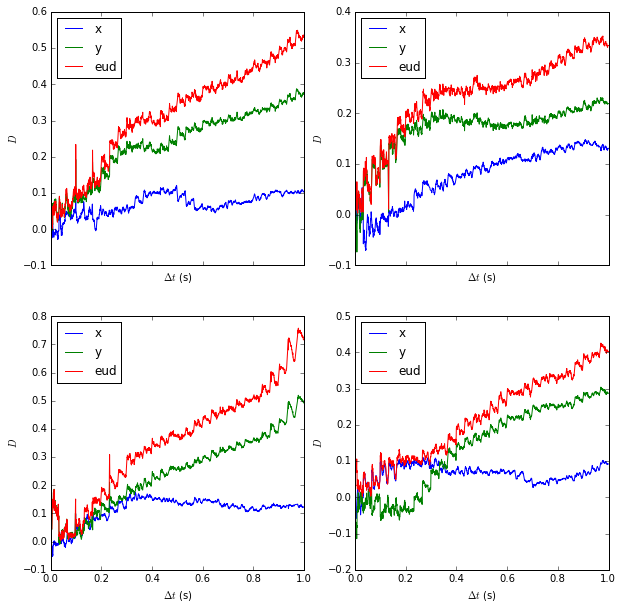

In [51]:
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialsf) / ncol))

for i, pl in enumerate(ax.flatten()):

    trial = trialsf[i]
   
    ##our values for trial.x are already relative to t=0.    
    ##make first 2 values 1 so we don't divide by zero
    ranger = np.sqrt(np.array([1]+range(1,len(trial.time))))
    xdn = trial.x/ranger
    ydn = trial.y/ranger
    eudn = ((trial.x**2 + trial.y**2)**(1/1.8))/ranger
    
    pl.plot(trial.time, xdn, label= 'x')
    pl.plot(trial.time, ydn, label= 'y')
    pl.plot(trial.time, eudn, label= 'eud')
    
    #pl.set_xscale('log')
    #pl.set_yscale('log')

    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D$')
    
    pl.legend(loc = 0)

#fig.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)

Doens't relaly look that much different.

## Beyond E&K 
The question still remains though, is this diffusion model sufficient? How well does it really represent the data? The line with slope $H$ seems to match when we plot our data based on equation $$ D^2 (m) = \frac{1}{N-m}\sum_{i=1}^{N-m}\|{\vec{x}_{i+m} - \vec{x}_i}\|^2$$ where $N$ is number of samples in recorded time series, $m$ is time lag measured as number of data samples, $x_i$ is the position at time $i$, and $D$ is the displacement over the given lag time.  

Now we fit a velocity model to the data...

### Implemeting Kalmnn Filter (Adapted from Alex's Code)

The Kalmann filter in Python is pykalman KalmanFilter. We will be modeling position and velocity for x and for y.  

It takes some parameters: 

1. initial_state_mean: (4x1 vector) zero for all parameters. This means we start at value zero for position and velocity, for both x and y.  

2. initial_state_covariance: (4x4 matrix) observation noise for x, and y postiion (assumed same), zero for everything else. This means we include stoichasity at the expected value for change in velocity at each time step.  

3. transition_matrices: (4x4 matrix) 1 along diagnoals, dt at velocity values for transitions, zero everywhere else. This means at each timestep, we keep our position, and add dt (velocity).  

4. transition_covariance: (4x4 matrix) hidden state transition noise at transition values for x and y velocity (assumed same), zero everywhere else. This means we include stoichaisity at the noise rate when we take a timestep.  

5. observation_matrices: (4x2 matrix) zero for velocity values (we don't observe them), 1 for position values. This means we observe x position and y position, the 1st and 3rd values in the vector (intial state mean).  

6. observation_covriance: (2x2 matrix) observation noise on x and y position, 0 everywhere else. This means we have some error in observing position for x and for y.  

The parameters we need to choose then are (for x and y) :

1. initial position covariance **(ivx, ivy) **   
    Estimate this by variance of the first two velocities  
    
2. velocity transition matrix **(dtx, dty)  **  
    This is the time from one frame to another in order to correctly calculate velocity. 1/numberofframes
    
3. velocity transition covariance **(tvx, tvy) **   
    Estimating this by the variance of velocity gives much too large numbers, because in reality our hidden state transition covariance is much lower than what we measure. So use a search to find the best one.
    
3. observation noise covariance **(ov)  **  
    This is known from Arathorn 2009 -> SD = 0.25
    
First define our function for fft filtering

In [167]:
def filterfft(trialsf, dcor):
    
    #make a new list so we dont edit the old one
    ntrialsf = copy.deepcopy(trialsf)
    
    for i, pl in enumerate(ax.flatten()):
        trial = ntrialsf[i]
        
        #print 'x is %d',trial.x
        #print 'y is %d',trial.y
        
        ##calculate velocities:
        #xv = (trial.x[1:] - trial.x[:-1]) * len(trial.time)
        #yv = (trial.y[1:] - trial.y[:-1]) * len(trial.time)
        xv = trial.xv
        yv = trial.yv
        #print 'xv is %d',xv
        #print 'yv is %d',yv
        
        ##IV is the covariance of the initial position.
        ##Because the initial velocity is a gaussian about zero, 
        ##we can estimate it by the average value of velocity.
        #iscvx =  10  #initial velocity std (in arcmin/s)
        #iscvy =  10  #initial velocity std (in arcmin/s)
        ivx =  np.std([xv[1],xv[0]])**2  #initial position covariance (in arcmin/s)
        ivy =  np.std([yv[1],yv[0]])**2  #initial position covariance (in arcmin/s)
        #ivx = 0
        #ivy = 0
        #print 'ivx is %d',ivx
        #print 'ivy is %d',ivy
        
        ##dt is the time transition matrix - how much we change in 1 frame in time scale
        dtx = 1./len(trial.time)
        dty = 1./len(trial.time)
        #print 'dtx is %d',dtx
        #print 'dty is %d',dty

        ##TV is the hidden state transition noise.
        ##This corresponds to the change in velocity (magnitude of accelleration)        
        #tvx = 0.04
        #tvy = 0.04
        #dvcor = 50
        tvx =  (np.std(xv)/dcor)**2 #velocity transition variation (average acceleration)
        tvy =  (np.std(yv)/dcor)**2 #velocity transition variation (average acceleration)
        #print 'tvx is %d',tvx
        #print 'tvy is %d',tvy
        
        ##OV is the observation noise. 
        ##This is equivalent to the noise that we expect in our measurement.
        ##We know that the AOSLO has an SD of error POSITION measurement of 0.2-0.3 arcmin (Arathorn, 2007)
        ##We assume this is the same in the x an y directions.
        ##variance = $SD^2$
        ov = 0.26**2
        #ov = 0.26
        #print 'ov is %d',ov
        

        ##matrices:
        initial_state_mean = np.array([0, 0, 0, 0])

        initial_state_cov = np.array([[0, 0, 0, 0], 
                                      [0, ivx, 0, 0], 
                                      [0, 0, 0, 0],
                                      [0, 0, 0, ivy]])

        transition_mat = np.array([[1, dtx, 0, 0],
                                   [0, 1, 0, 0], 
                                   [0, 0, 1, dty],
                                   [0, 0, 0, 1]])

        transition_cov = np.array([[0, 0, 0, 0], 
                                   [0, tvx, 0, 0], 
                                   [0, 0, 0, 0],
                                   [0, 0, 0, tvy]])

        observation_mat = np.array([[1, 0, 0, 0],
                                    [0, 0, 1, 0]])

        observation_cov = np.array([[ov, 0], 
                                    [0, ov]])

        ##initialize filter 
        kf = KalmanFilter(initial_state_mean = initial_state_mean,
                          initial_state_covariance = initial_state_cov,
                          transition_matrices = transition_mat,
                          transition_covariance = transition_cov,
                          observation_matrices = observation_mat,
                          observation_covariance = observation_cov
                          #em_vars=['transition_covariance']
                          #em_vars=['initial_state_covariance','transition_covariance']
                          #em_vars=['initial_state_covariance','transition_covariance','observation_covariance']
                          #em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
                          )

        ##make matrix of measurements
        measurements = np.vstack((trial.x,trial.y)).T

        ##estimate parameters
        #kf.em(measurements, n_iter=5)
        (smoothed_state_means, smoothed_state_cov) = kf.smooth(measurements)

        #Xh = smoothed_state_means[:, (0,2)]
        #Vh = smoothed_state_means[:, (1,3)]
        trial.x = smoothed_state_means[:, 0]
        trial.y = smoothed_state_means[:, 2]
        trial.xv = smoothed_state_means[:, 1]
        trial.yv = smoothed_state_means[:, 3]
        #trial.xv = np.concatenate([[trial.x[1] - trial.x[0]],
        #                             trial.x[1:] - trial.x[:-1]]) ##* len(trial.time) #in seconds
        #trial.yv = np.concatenate([[trial.y[1] - trial.y[0]],
        #                             trial.y[1:] - trial.y[:-1]]) ##* len(trial.time) #in seconds
        
        #trial.xv = np.concatenate([[np.subtract(trial.x[1], trial.x[0])], 
        ##                           np.subtract(trial.x[1:], trial.x[:-1])]
        #                           ) * trial.time ##in seconds
        
        #trial.yv = np.concatenate([[np.subtract(trial.y[1], trial.y[0])],
        ##                          np.subtract(trial.y[1:],  trial.y[:-1])]
        #                         ) * trial.time ##in seconds
            

        trial.filterinfo = trial.filterinfo + '3) Kahlman Filter applied with paramters: tvx=%s, tvy=%s, ov=%s, ivx=%s, sigmapy=%s, dtx=%s, dty=%s.\n' % (tvx, tvy, ov, ivx, ivy, dtx, dty)
        trial.kfivx = ivx
        trial.kfivy = ivy
        trial.kftvx = tvx
        trial.kftvy = tvy
        trial.kfov = ov
        trial.kfdtx = dtx
        trial.kfdty = dty
        
        
    return ntrialsf

Now try a range of parameters for tvx and tvy to chose the best value for our filter. Instead of defining tvx and tvy separately, define 'dvcor' a number we divide our measured covariance by in order to estimate the true covariance. Our metric of correctness is the mean difference between the transition covariance of our smoothed data, and the value we estimated.

In [ ]:
testvals = 10
dvcorvs = range(0,testvals)
dvcorvs = np.power(10, dvcorvs)

errx = np.zeros(len(dvcorvs))
erry = np.zeros(len(dvcorvs))

for index,val in enumerate(dvcorvs):
    #my cor ranges 1:10:100:1000:10000:100000... etc
    #mydvcor = 1*10**inex
    trialskftest = filterfft(trialsf, val)
    meansx = np.zeros(len(trialskftest))
    meansy = np.zeros(len(trialskftest))
    for j in xrange(len(trialskftest)):
        #print j
        trial = trialskftest[j]
        xerror = round(np.abs(trial.kftvx - np.std(trial.xv)**2),0)
        yerror = round(np.abs(trial.kftvy - np.std(trial.yv)**2),0)
        #print xerror
        #print yerror
        meansx[j] = xerror
        meansy[j] = yerror
        #print 'tv: ',round(trial.kftvx,0),round(trial.kftvy,0)
        #print 'error: ',xerror,yerror
    errx[index] = np.mean(meansx)
    erry[index] = np.mean(meansy)
    #print 'dvcor: ',round(mydvcor,0)
    #print 'meanerr: ',round(meanerr,0)
    #print '--------'

plt.plot(dvcorvs,errx, label = 'x err')
plt.plot(dvcorvs,erry, label = 'y err')

plt.ylabel('Divisor for tv')
plt.ylabel('Error in filter')

plt.xscale('log')
plt.yscale('log')

plt.title('Error in x and y')
plt.legend(loc = 1)


In [170]:
?abs

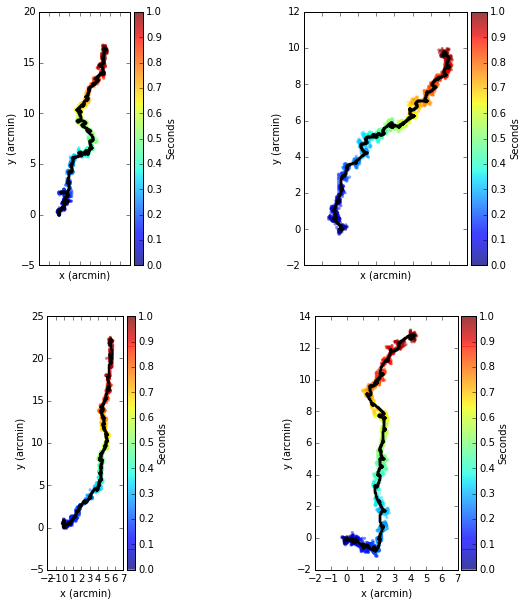

In [104]:
#run fft with chosen parameter for dvcor and plot results
mydvcor = 10
trialskf = filterfft(trialsf, mydvcor)

##plot our new results

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialskf) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

for i, pl in enumerate(ax.flatten()):
    trial = trialskf[i]
    ##plot original data
    imraw = pl.scatter(trial.xraw, trial.yraw, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    pl.scatter(trial.x, trial.y, s=2, c='black')

plt.show()
    

It's hard to tell which parameters are best by trial and error, espeically for the parameter 

We have smoothed to some degree here. Because we choose slightly different parameters here than Alex chose, we have a very slightly different smoothing, but still similar.

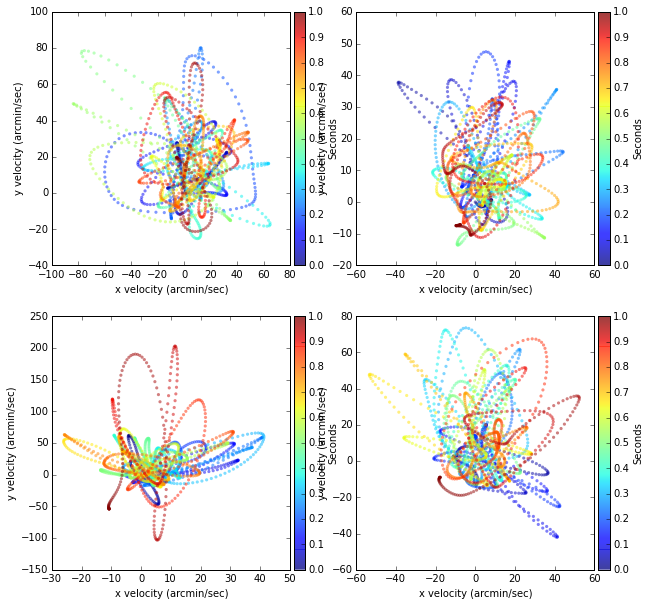

In [105]:
##plot our new results for velocity

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialskf) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = trialskf[i]
    ##plot original data
    imraw = pl.scatter(trial.xv, trial.yv, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x velocity (arcmin/sec)')
    pl.set_ylabel('y velocity (arcmin/sec)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')

plt.show()

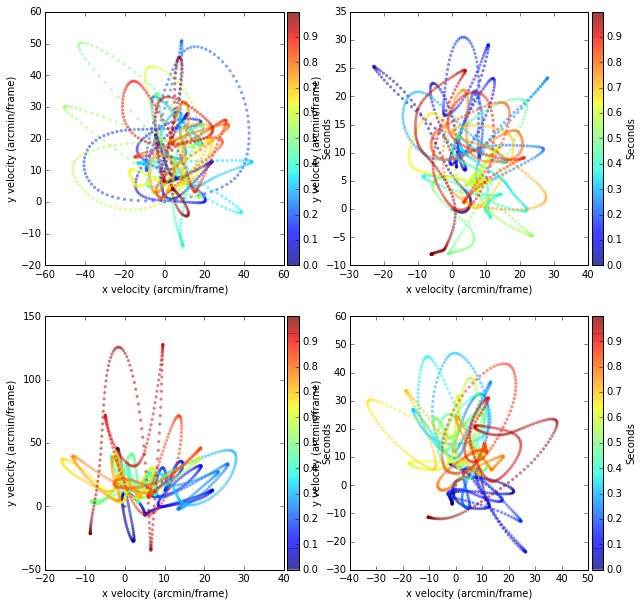

In [79]:
###### plot our new results for velocity

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialskf) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = trialskf[i]
    ##plot original data
    imraw = pl.scatter((trial.x[1:] - trial.x[:-1])*len(trial.time), (trial.y[1:] - trial.y[:-1])*len(trial.time), s=10, c=trial.time[:-1], cmap=cm.jet, alpha=0.5, edgecolors='none')
    #imraw = pl.scatter(trial.xv, trial.yv, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x velocity (arcmin/frame)')
    pl.set_ylabel('y velocity (arcmin/frame)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')

plt.show()

This looks a whole lot more realistic for a velocity progression than our pre-filtering plot of velocity.  Also, the smooth velocities from the KF and the velocitied inferred from the smoothed positions are equivalent. This means the velocity is being calculated correctly. Interestinly, these are quite different velocities than when we used a different value for dx. This makes some sense because we are multiplying the velocity by a different number every time.

Let's now look at acceleration.

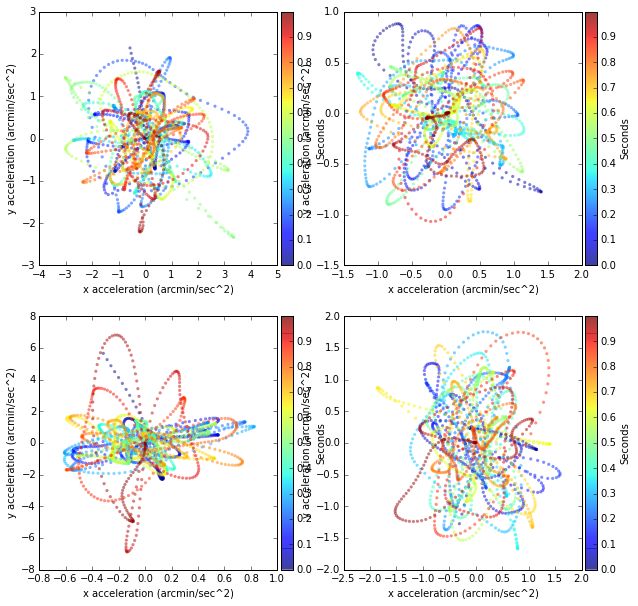

In [89]:
###### plot our new results for acceleration

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialskf) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = trialskf[i]
    ##plot original data
    imraw = pl.scatter((trial.xv[1:] - trial.xv[:-1]), (trial.yv[1:] - trial.yv[:-1]), s=10, c=trial.time[:-1], cmap=cm.jet, alpha=0.5, edgecolors='none')
    #imraw = pl.scatter(trial.xv, trial.yv, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x acceleration (arcmin/sec^2)')
    pl.set_ylabel('y acceleration (arcmin/sec^2)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')

plt.show()

This is SMOOTH for some reason. Why? We only model position and velocity, not position, so this is strange that the acceleration value changes smoothly through the time course, as I would have expected it to prog


Let's now validate our model parameters.

### Validating Model Parameters:

We need to validate our chosen values for:   

**tvx, tvy** (transition covariance)  
       change in velocity is instintaneous accelleration  
       tvx =  np.std(xv)^2  
       tvy =  np.std(yv)^2   
    
**ov** (observation covariance)  
        AOSLO error in measurement(Arathorn, 2007)  
        ov = (0.26)^2   

#### Values before and after

First we compare our parameters before and after filtering.

In [80]:
for i in range(0,len(trialskf)):
    trial = trialskf[i]
    print 'trial %d',i
    print 'param tvx is %d',trial.kftvx
    print 'filtered covariance of velocity is %d',np.std(trial.xv)**2
    print 'param tvy is %d',trial.kftvy
    print 'filtered covariance of velocity is %d',np.std(trial.yv)**2

trial %d 0
param tvx is %d 17.0737618003
filtered covariance of velocity is %d 237.947960993
param tvy is %d 6.37826908524
filtered covariance of velocity is %d 141.219833822
trial %d 1
param tvx is %d 7.18388275214
filtered covariance of velocity is %d 81.0909109372
param tvy is %d 4.13625635856
filtered covariance of velocity is %d 62.6932086988
trial %d 2
param tvx is %d 2.07677630846
filtered covariance of velocity is %d 73.0201544883
param tvy is %d 7.13159695272
filtered covariance of velocity is %d 513.742410204
trial %d 3
param tvx is %d 6.24652911912
filtered covariance of velocity is %d 112.488949767
param tvy is %d 4.78773341873
filtered covariance of velocity is %d 173.263788118


#### Histograms of Velocity

Next we look at our choice of dt. dt is the velocity at each timestep.

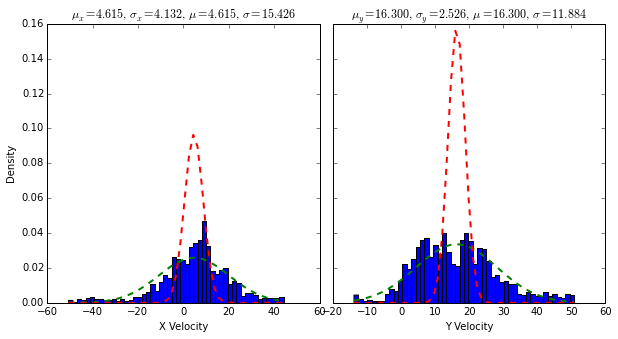

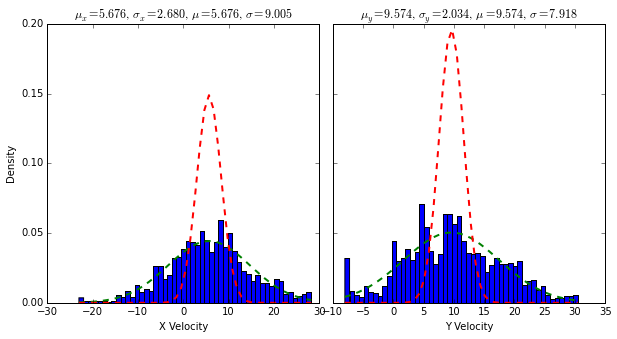

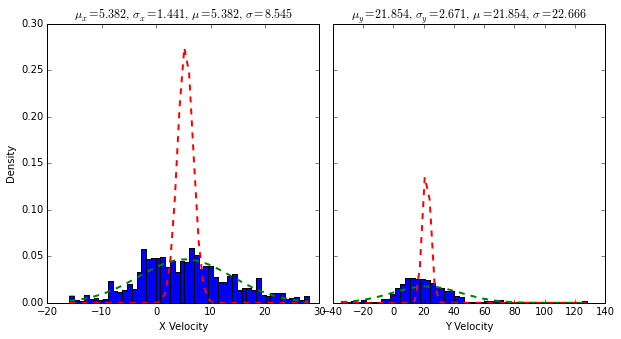

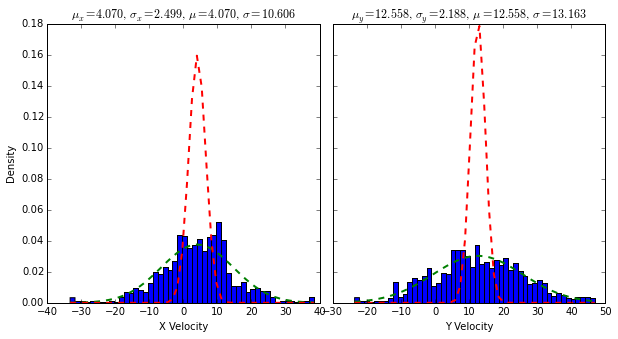

In [86]:
import matplotlib.mlab as mlab
from scipy.stats import norm

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialskf) / ncol))

for i in range(0,len(trialskf)):
    
    trial = trialskf[i]
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,5))

    ##X
    ##hist of data
    xn, xbins, xpatches = ax1.hist(trial.xv, normed=1, bins = 50)

    # best fit of data
    (xmu,xsigma) = norm.fit(trial.xv)
    xfit = mlab.normpdf(xbins, xmu, xsigma)
    ax1.plot(xbins, xfit, 'g--', linewidth=2)
    
    # best fit of params
    trialmu = np.mean(trial.xv)
    trialsig = np.sqrt(trial.kftvx)
    sigmapxfit = mlab.normpdf(xbins, trialmu, trialsig)
    ax1.plot(xbins, sigmapxfit, 'r--', linewidth=2)
    
    ##labels
    ax1.set_xlabel('X Velocity')
    ax1.set_ylabel('Density')
    
    ##Y 
    ##hist of data
    yn, ybins, ypatches = ax2.hist(trial.yv, normed=1, bins = 50)
      
    # best fit of data
    (ymu,ysigma) = norm.fit(trial.yv)
    yfit = mlab.normpdf(ybins, ymu, ysigma)
    ax2.plot(ybins, yfit, 'g--', linewidth=2)
    
    # best fit of params
    trialmu = np.mean(trial.yv)
    trialsig = np.sqrt(trial.kftvy)
    sigmapyfit = mlab.normpdf(ybins, trialmu, trialsig)
    ax2.plot(ybins, sigmapyfit, 'r--', linewidth=2)
    
    ##labels
    ax2.set_title(r'$\mu_{y}=%.3f,\ \sigma_{y}=%.3f,\ \mu=%.3f,\ \sigma=%.3f$' %(round(trialmu,3), round(trialsig,3), ymu, ysigma))
    ax2.set_xlabel('Y Velocity')
    
    ##tidy up
    fig.subplots_adjust(hspace=1, wspace=.05)
    

plt.show()

#### Histograms of Acceleration

Now look at our choice of Sigmat
Sigmat is the std in velocity change aka noise aka acceleration

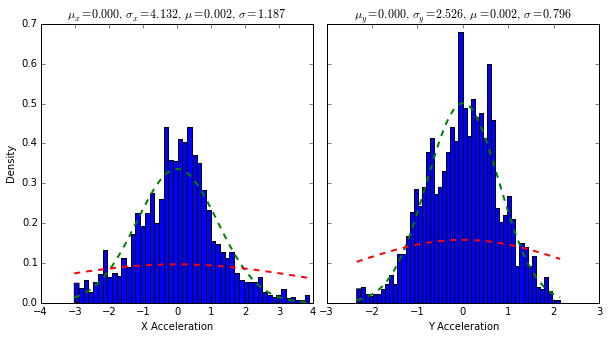

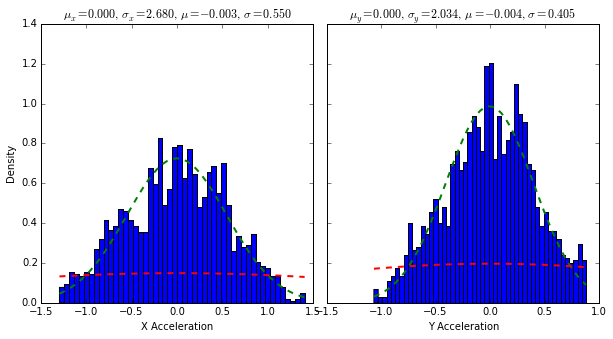

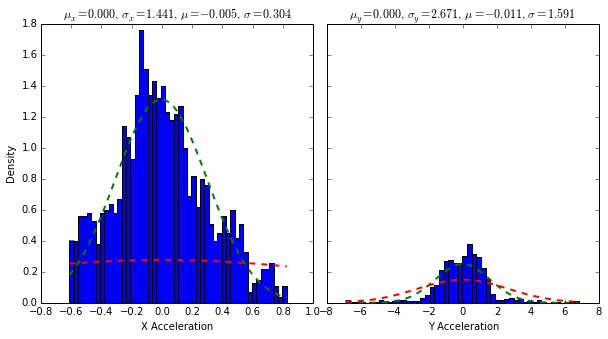

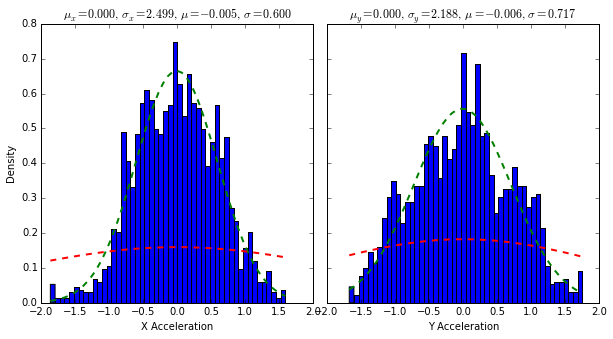

In [97]:
import matplotlib.mlab as mlab
from scipy.stats import norm

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialskf) / ncol))

for i in range(0,len(trialskf)):
    
    trial = trialskf[i]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,5))

    ##x - calculate acceleration (noise in velocity)
    xa = trial.xv[1:] - trial.xv[:-1]
    ##plot data
    xn, xbins, xpatches = ax1.hist(xa, normed=1, bins = 50)
    
    # best fit of data
    (xmu,xsigma) = norm.fit(xa)
    xfit = mlab.normpdf(xbins, xmu, xsigma)
    ax1.plot(xbins, xfit, 'g--', linewidth=2)
    
    # best fit of params
    trialmu = 0 #np.mean(xa)
    trialsig = np.sqrt(trial.kftvx)
    sigmatxfit = mlab.normpdf(xbins, trialmu, trialsig)
    ax1.plot(xbins, sigmatxfit, 'r--', linewidth=2)
    
    ##labels
    ax1.set_title(r'$\mu_{x}=%.3f,\ \sigma_{x}=%.3f,\ \mu=%.3f,\ \sigma=%.3f$' %(round(trialmu,3), round(trialsig,3), xmu, xsigma))
    ax1.set_xlabel('X Acceleration')
    ax1.set_ylabel('Density')     
     
    ##y - calculate acceleration (noise in velocity)
    ya = trial.yv[1:] - trial.yv[:-1]
    yn, ybins, ypatches = ax2.hist(ya, normed=1, bins = 50)
    
    # best fit of data
    (ymu,ysigma) = norm.fit(ya)
    yfit = mlab.normpdf(ybins, ymu, ysigma)
    ax2.plot(ybins, yfit, 'g--', linewidth=2)
    
    # best fit of params
    trialmu = 0 #np.mean(ya)
    trialsig = np.sqrt(trial.kftvy)
    sigmatyfit = mlab.normpdf(ybins, trialmu, trialsig)
    ax2.plot(ybins, sigmatyfit, 'r--', linewidth=2)
    
    ##labels
    ax2.set_title(r'$\mu_{y}=%.3f,\ \sigma_{y}=%.3f,\ \mu=%.3f,\ \sigma=%.3f$' %(round(trialmu,3), round(trialsig,3), ymu, ysigma))
    ax2.set_xlabel('Y Acceleration')

    ##tidy up
    fig.subplots_adjust(hspace=1, wspace=.05)
    
plt.show()

Looks like we are fitting well.

#### Histograms of Observation noise

Now look at our choice of Sigmao

In [ ]:
import matplotlib.mlab as mlab
from scipy.stats import norm

##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(trialskf) / ncol))

for i in range(0,len(trialskf)):
    
    trial = trialskf[i]
    trialo = trialsf[i]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,5))
    
    ##X
    ##calculate observation noise (difference between smoothed and previous value)
    xa = trial.x - trialo.x
    xn, xbins, xpatches = ax1.hist(xa, normed=1, bins = 50)
    
    # best fit of data
    (xmu,xsigma) = norm.fit(xa)
    xfit = mlab.normpdf(xbins, xmu, xsigma)
    ax1.plot(xbins, xfit, 'g--', linewidth=2)
    
    ##labels
    ax1.set_title(r'$\sigma o_x=%.3f,\ \mu=%.3f,\ \sigma=%.3f$' %(round(trial.kfsigmao,3), xmu, xsigma))
    ax1.set_xlabel('X Noise')
    ax1.set_ylabel('Density')     
    
    # best fit of data
    (xmu,xsigma) = norm.fit(xa)
    xfit = mlab.normpdf(xbins, xmu, xsigma)
    ax1.plot(xbins, xfit, 'g--', linewidth=2)
    
    # best fit of params
    sigmaoxfit = mlab.normpdf(xbins, 0, trial.kfsigmao)
    ax1.plot(xbins, sigmaoxfit, 'r--', linewidth=2)
  

    ##y 
    ##calculate observation noise (difference between smoothed and previous value)
    ya = trial.y - trialo.y
    yn, ybins, ypatches = ax2.hist(ya, normed=1, bins = 50)
    
    # best fit of data
    (ymu,ysigma) = norm.fit(ya)
    yfit = mlab.normpdf(ybins, ymu, ysigma)
    ax2.plot(ybins, yfit, 'g--', linewidth=2)
    
    ##labels
    ax2.set_title(r'$\sigma o_y=%.3f,\ \mu=%.3f,\ \sigma=%.3f$' %(round(trial.kfsigmao,3), ymu, ysigma))
    ax2.set_xlabel('Y ANoise')
    
    # best fit of data
    (ymu,ysigma) = norm.fit(ya)
    yfit = mlab.normpdf(ybins, ymu, ysigma)
    ax2.plot(ybins, yfit, 'g--', linewidth=2)
    
    # best fit of params
    sigmaoyfit = mlab.normpdf(ybins, 0, trial.kfsigmao)
    ax2.plot(ybins, sigmaoyfit, 'r--', linewidth=2)

    ##tidy up
    fig.subplots_adjust(hspace=1, wspace=.05)
    
plt.show()

There must me something interesting to say about how these histograms validate or invalidate our choice of KF parameters. Do some research to find out.

In [ ]:
trialskf[2].kfsigmatx

In [ ]:
trialskf[3].kfsigmatx

In [ ]:
print('x')
trial = trialskf[1]
print np.mean(trial.xv[0])
print (trial.x[1] - trial.x[0]) * len(trial.y)
print('y')
print np.mean(trial.yv[0])
print (trial.y[1] - trial.y[0]) * len(trial.y)

In [ ]:
print('x')
print ntrialsf[1].x[0]
print ntrialsf[1].x[1]
print trialskf[1].x[0]
print trialskf[1].x[1]
print('velocity')
print ntrialsf[1].xv[0]
print trialskf[1].xv[0]
print ntrialsf[1].xv[1]
print trialskf[1].xv[1]
print trialskf[1].kfdtx
1./len(trialskf[1].time)
print('y')
